https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data/code

In [1]:
!pip install numpy==1.23.4

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import scipy.stats as stats
import pylab 

import shap
import re

from sklearn.feature_selection import mutual_info_regression

import lightgbm as lg
import xgboost as xg

/Users/keithlowton/anaconda3/envs/Regressions/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/keithlowton/anaconda3/envs/Regressions/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for deta

### Functions

In [3]:
#################################
### Variance inflation factor ###
#################################

def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]    
    return(vif)

In [4]:
##############################
### Min-Max transformation ###
##############################

def minmax_dset(dset,numeric_columns):

    dseta = dset.copy()
    dsetb = pd.DataFrame(transformer_train.transform(dseta[numeric_columns]))
    dsetb.columns = numeric_columns
    print(dsetb.shape)
    return dsetb

In [5]:
########################
### One hot encoding ###
########################

def ohe_dset(dset,categorical_columns):

    dseta = dset.copy()
    transformed_dset = ohe.fit_transform(dseta[categorical_columns])
    cat_data = pd.DataFrame(transformed_dset.toarray())
    cat_data.columns = ohe.get_feature_names_out(input_features=dseta[categorical_columns].columns)
    print(cat_data.shape)
    return cat_data

In [6]:
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

### Read the data

In [7]:
df1 = pd.read_csv('vehicles.csv', sep = ',')
print(df1.shape)
df1.head()

(426880, 26)


id                                                url  \
0  7222695916  https://prescott.craigslist.org/cto/d/prescott...   
1  7218891961  https://fayar.craigslist.org/ctd/d/bentonville...   
2  7221797935  https://keys.craigslist.org/cto/d/summerland-k...   
3  7222270760  https://worcester.craigslist.org/cto/d/west-br...   
4  7210384030  https://greensboro.craigslist.org/cto/d/trinit...   

                   region                         region_url  price  year  \
0                prescott    https://prescott.craigslist.org   6000   NaN   
1            fayetteville       https://fayar.craigslist.org  11900   NaN   
2            florida keys        https://keys.craigslist.org  21000   NaN   
3  worcester / central MA   https://worcester.craigslist.org   1500   NaN   
4              greensboro  https://greensboro.craigslist.org   4900   NaN   

  manufacturer model condition cylinders  ... size  type paint_color  \
0          NaN   NaN       NaN       NaN  ...  NaN   NaN         NaN   
1          NaN   NaN       NaN       NaN  ...  NaN   NaN         NaN   
2          NaN   NaN       NaN       NaN  ...  NaN   NaN         NaN   
3          NaN   NaN       NaN       NaN  ...  NaN   NaN         NaN   
4          NaN   NaN       NaN       NaN  ...  NaN   NaN         NaN   

  image_url description county state lat long posting_date  
0       NaN         NaN    NaN    az NaN  NaN          NaN  
1       NaN         NaN    NaN    ar NaN  NaN          NaN  
2       NaN         NaN    NaN    fl NaN  NaN          NaN  
3       NaN         NaN    NaN    ma NaN  NaN          NaN  
4       NaN         NaN    NaN    nc NaN  NaN          NaN  

[5 rows x 26 columns]

In [8]:
df = df1.drop_duplicates()

#print(list(df.columns))

df['row_miss'] = df.isnull().sum(axis=1)
df = df[(~df.year.isna()) & (df.year >= 2010) & (df['row_miss'] <= 2) & (df.price <= 554900) & 
        (df.price > 98) & (df.odometer > 10) & (df.year <= 2021)]
for name in ['year','price']:
    df[name] = df[name].astype(int)

df = df.drop(['county'], axis = 1)

for name in ['transmission','drive','condition','cylinders','fuel','manufacturer','model','type','paint_color']:
    df[name + '_miss'] = 0
    df.loc[df[name].isna(),name + '_miss'] = 1
    df.loc[df[name].isna(),name] = 'Missing'
df.loc[df['title_status'].isna(),'title_status'] = 'missing'   
df.loc[df['size'].isna(),'size'] = 'miss'  

for name in ['region','model','cylinders','size','manufacturer','region']:
    df[name] = df[name].str.replace(r'-', r'_')
    df[name] = df[name].str.replace(r' ', r'_')
    df[name] = df[name].str.replace(r'/', r'')
    df[name] = df[name].str.replace(r',', r'')
    df[name] = df[name].str.replace(r'__', r'_')

df.posting_date = pd.to_datetime(df.posting_date, utc=True)
add_datepart(df, 'posting_date', drop=True, time=True)

print(df.shape)

(65524, 50)


Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.


In [9]:
#pd.crosstab(df['size'], columns = 'Count')

In [10]:
check = pd.crosstab(df['row_miss'],columns = 'Count')
check = check.reset_index()
check = check.sort_values(by = 'row_miss', ascending = True)
check['Cum_count'] = check['Count'].cumsum() 
check = check.reset_index(drop=True)
df = df.drop(['row_miss'], axis = 1)
#check

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65524 entries, 31 to 426878
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        65524 non-null  int64  
 1   url                       65524 non-null  object 
 2   region                    65524 non-null  object 
 3   region_url                65524 non-null  object 
 4   price                     65524 non-null  int64  
 5   year                      65524 non-null  int64  
 6   manufacturer              65524 non-null  object 
 7   model                     65524 non-null  object 
 8   condition                 65524 non-null  object 
 9   cylinders                 65524 non-null  object 
 10  fuel                      65524 non-null  object 
 11  odometer                  65524 non-null  float64
 12  title_status              65524 non-null  object 
 13  transmission              65524 non-null  object 
 14  VIN 

In [12]:
a = pd.DataFrame(df.isna().mean().round(4) * 100, columns = ['Count'])
a[a.Count > 0]

Count
VIN  28.89

In [13]:
#pd.crosstab(df.odometer.isna(), columns = 'Count')

In [14]:
for i in range(df.shape[1]):
    print(f"The number of unique classes for {df.columns[i]} is {df.iloc[:,i].nunique()}")
    if df.iloc[:,i].nunique() < 15:
        print(f"    The classes are {df.iloc[:,i].unique()}")

The number of unique classes for id is 65524
The number of unique classes for url is 65524
The number of unique classes for region is 402
The number of unique classes for region_url is 412
The number of unique classes for price is 4579
The number of unique classes for year is 12
    The classes are [2013 2012 2016 2011 2017 2018 2014 2019 2020 2010 2021 2015]
The number of unique classes for manufacturer is 41
The number of unique classes for model is 6390
The number of unique classes for condition is 7
    The classes are ['excellent' 'good' 'like new' 'new' 'Missing' 'salvage' 'fair']
The number of unique classes for cylinders is 9
    The classes are ['6_cylinders' '8_cylinders' '4_cylinders' '5_cylinders' '10_cylinders'
 'Missing' '3_cylinders' 'other' '12_cylinders']
The number of unique classes for fuel is 5
    The classes are ['gas' 'other' 'hybrid' 'diesel' 'electric']
The number of unique classes for odometer is 23204
The number of unique classes for title_status is 6
    The

### Graphs

In [15]:
# odometer                  1.895472
# year                      0.481514
# transmission_other        0.336398
# transmission_automatic    0.279279
# condition_good            0.259068
# size_Missing              0.258151
# size_miss                 0.257623
# cylinders_4_cylinders     0.207612
# drive_fwd                 0.196273
# posting_Minute            0.188791
# posting_Hour              0.165276
# condition_excellent       0.159280
# cylinders_8_cylinders     0.154459
# size_full_size            0.138204
# drive_4wd                 0.123662
# type_sedan                0.119382
# row_miss                  0.115212
# type_truck                0.105852
# type_pickup               0.104465

SyntaxError: invalid syntax (2177719514.py, line 1)

In [16]:
#odometer year transmission condition size cylinders drive posting type
#a = df[df.odometer < 10]
#pd.crosstab(a.odometer, columns = 'Count')

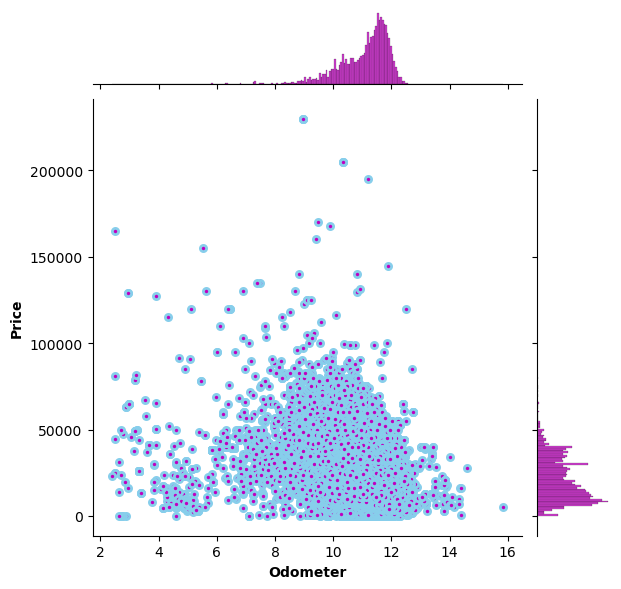

In [17]:
df['log_odometer'] = np.log(df['odometer'])

ax = sns.jointplot(x=df['log_odometer'], y=df['price'], kind='scatter', s=20, color='m', edgecolor="skyblue", linewidth=2)
ax.ax_joint.set_xlabel('Odometer', fontweight='bold')
ax.ax_joint.set_ylabel('Price', fontweight='bold')
plt.show()

#### Pie chart

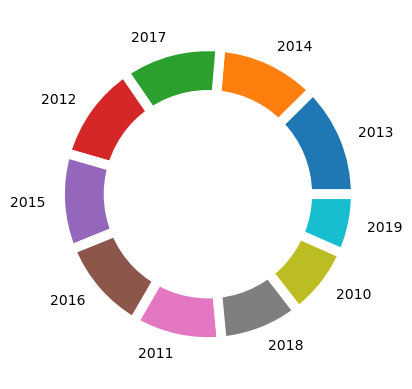

In [18]:
name = 'year'
c_loc = df.sort_values(by = name)
c_loc = c_loc.groupby([name])['price'].count()
c_loc = c_loc.reset_index()
c_loc['perc'] = c_loc['price']/df.shape[0] * 100
c_loc = c_loc.sort_values(by = 'perc', ascending = False)
c_loc['cum_perc'] = c_loc['perc'].cumsum() 
c_loc = c_loc.reset_index(drop=True)
c_loca = c_loc[c_loc.cum_perc < 99]

my_circle = plt.Circle( (0,0), 0.7, color='white')

# Custom wedges
plt.pie(c_loca.perc, labels=c_loca[name], wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [19]:
c_loc

year  price       perc    cum_perc
0   2013   7803  11.908614   11.908614
1   2014   7035  10.736524   22.645138
2   2017   6864  10.475551   33.120689
3   2012   6851  10.455711   43.576399
4   2015   6657  10.159636   53.736036
5   2016   6594  10.063488   63.799524
6   2011   6192   9.449973   73.249496
7   2018   5627   8.587693   81.837189
8   2010   4975   7.592638   89.429827
9   2019   4140   6.318296   95.748123
10  2020   2578   3.934436   99.682559
11  2021    208   0.317441  100.000000

#### Histograms

In [20]:
df.price.describe()

count     65524.000000
mean      21416.250427
std       13807.795834
min         100.000000
25%       10194.000000
50%       18000.000000
75%       29999.000000
max      229500.000000
Name: price, dtype: float64

In [21]:
#a = df[df.price < 100]
#pd.crosstab(df.price > 400000, columns = 'Count')
#pd.crosstab(a.price, columns = 'Count')

Ignoring `palette` because no `hue` variable has been assigned.


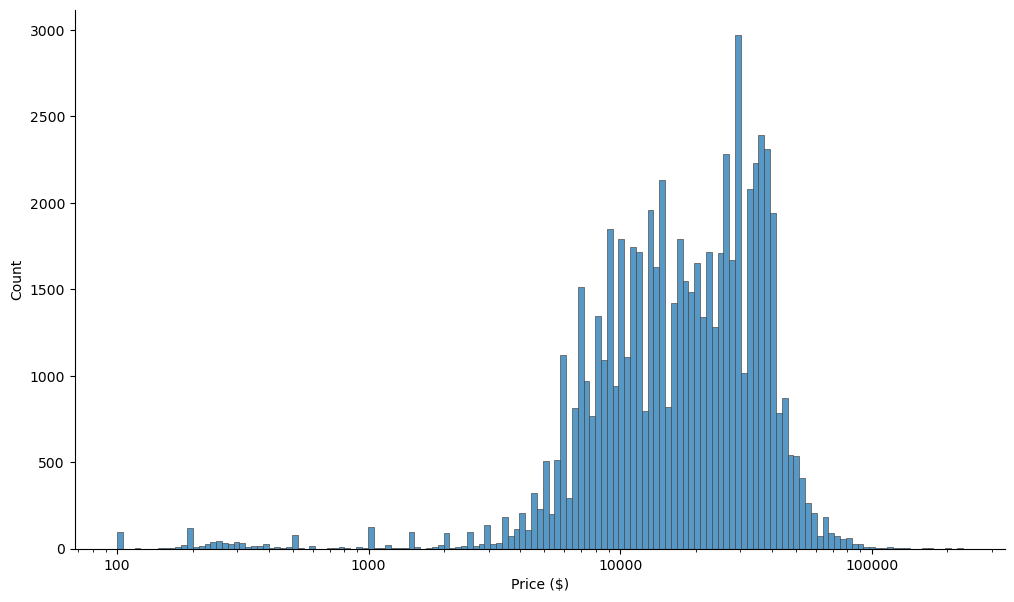

In [22]:
f, ax = plt.subplots(figsize=(12,7))
sns.despine(f)

sns.histplot(
    df,
    x="price", 
    palette="rainbow",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
#ax.set_xticks([5000, 10000, 20000, 15000000])

plt.xlabel("Price ($)")
plt.show();

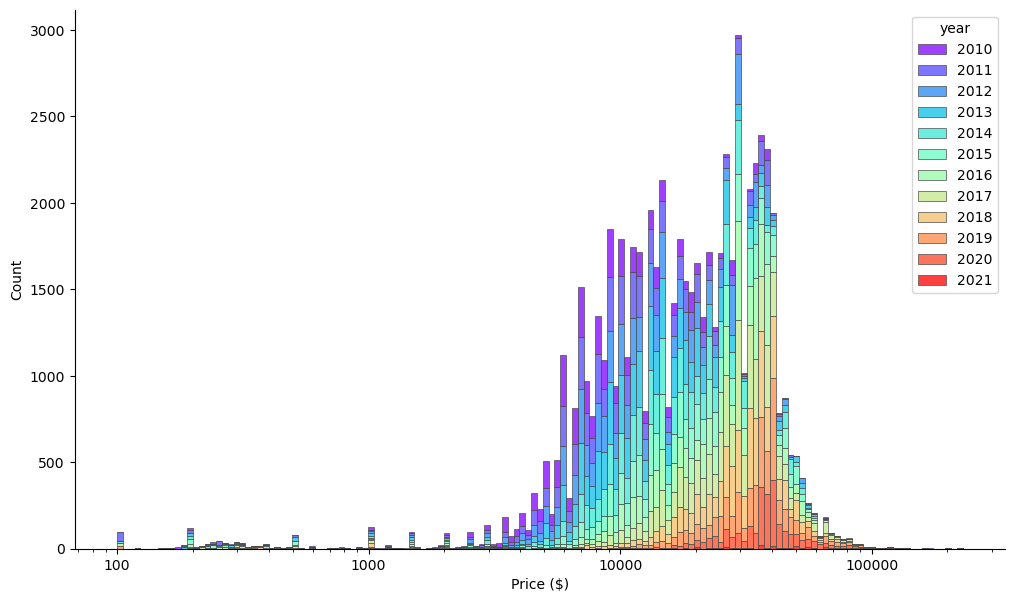

In [23]:
f, ax = plt.subplots(figsize=(12,7))
sns.despine(f)

sns.histplot(
    df,
    x="price", hue="year",
    multiple="stack",
    palette="rainbow",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

plt.xlabel("Price ($)")
plt.show();

#### Boxplots

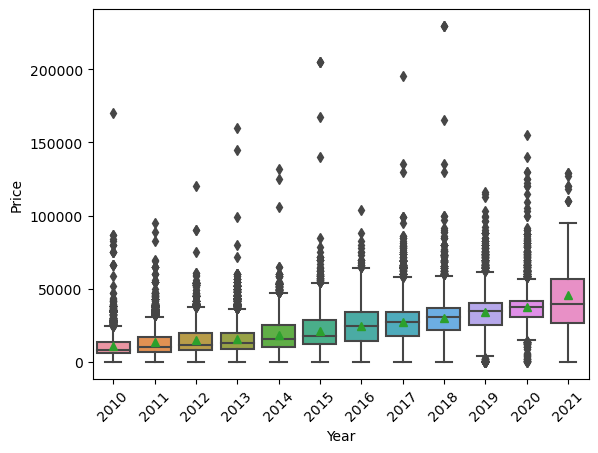

In [24]:
sns.boxplot(data=df, x="year", y="price", showmeans = True)
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.ylabel("Price")
plt.show()

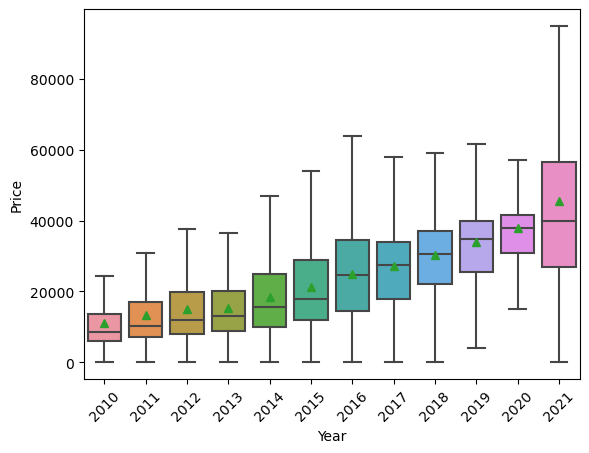

In [25]:
sns.boxplot(data=df, x="year", y="price", showfliers = False, showmeans = True)
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.ylabel("Price")
plt.show()

#### Relplots

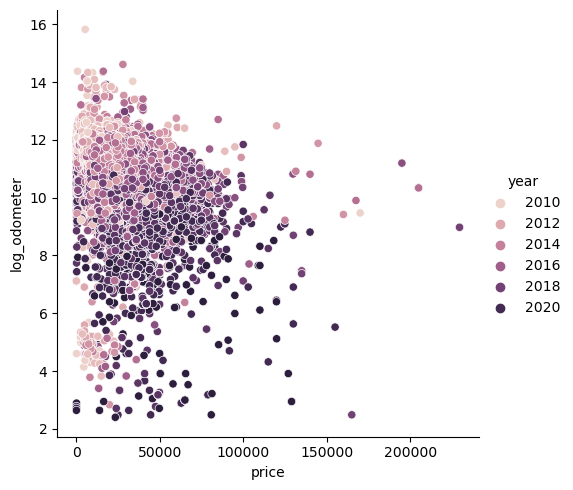

In [26]:
sns.relplot(x='price',
            y='log_odometer',
            data=df,
            kind='scatter',
            hue='year');
plt.show();

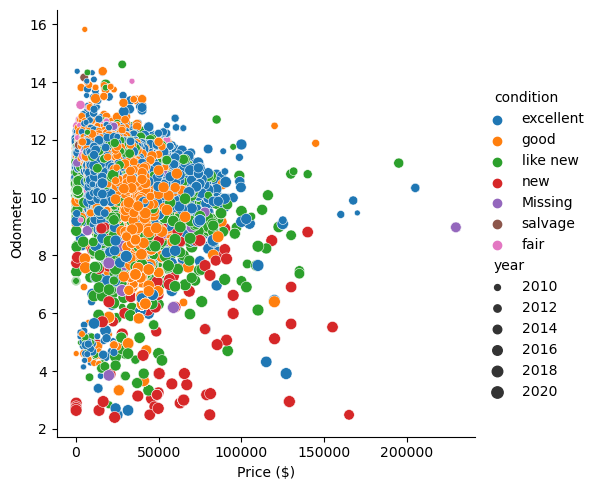

In [27]:
sns.relplot(x='price',
            y='log_odometer',
            data=df,
            kind='scatter',
            size='year',
            hue='condition')
plt.xlabel("Price ($)")
plt.ylabel("Odometer")
plt.show();

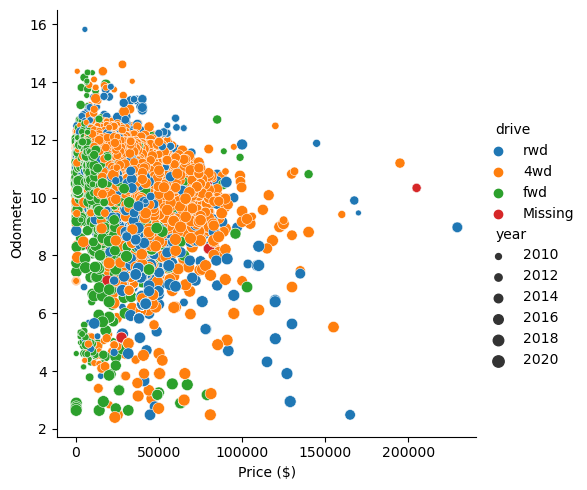

In [28]:
sns.relplot(x='price',
            y='log_odometer',
            data=df,
            kind='scatter',
            size='year',
            hue='drive')
plt.xlabel("Price ($)")
plt.ylabel("Odometer")
plt.show();

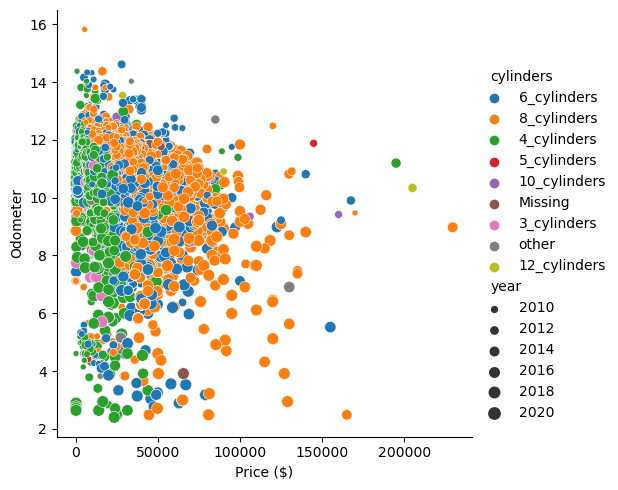

In [29]:
sns.relplot(x='price',
            y='log_odometer',
            data=df,
            kind='scatter',
            size='year',
            hue='cylinders')
plt.xlabel("Price ($)")
plt.ylabel("Odometer")
plt.show();

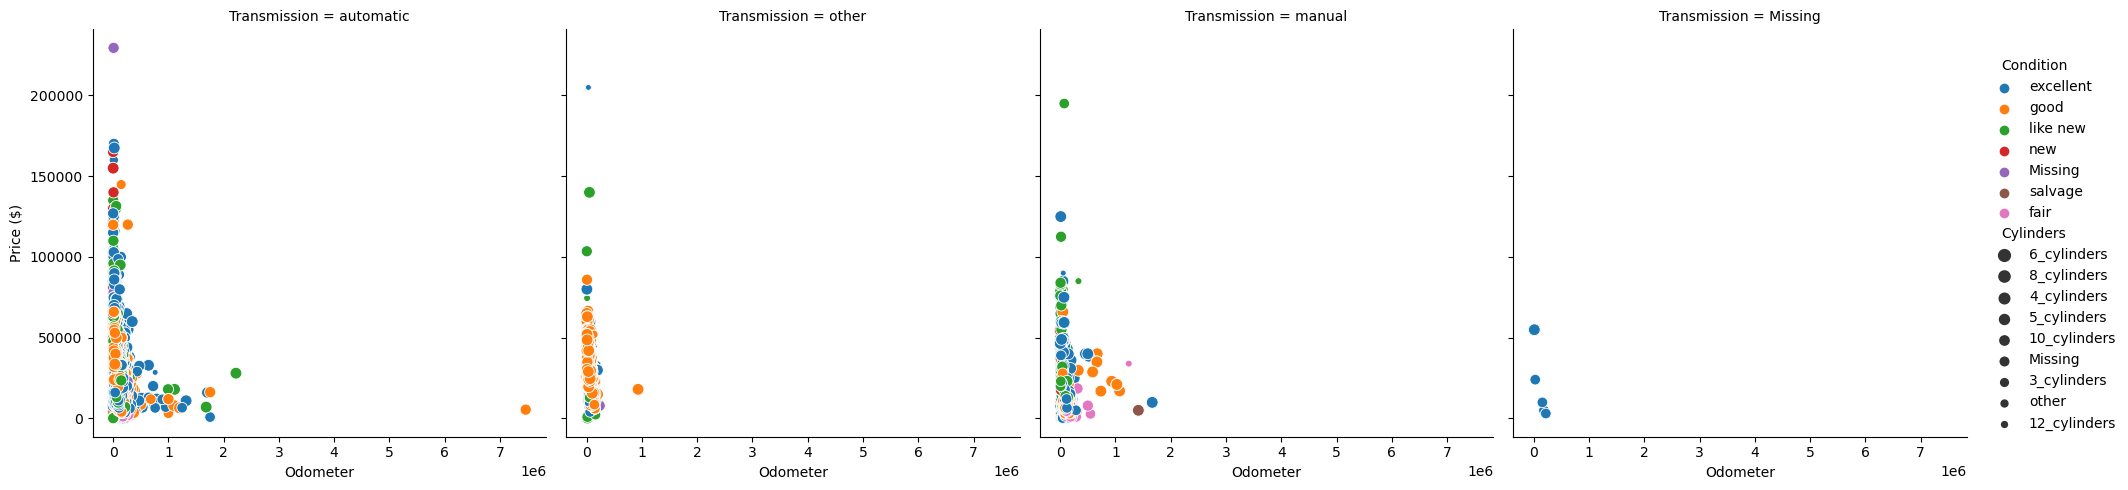

In [30]:
data_copy = df.copy()
data_copy.rename(columns = {'odometer':'Odometer',
                            'price':'Price ($)',
                            'cylinders':'Cylinders',
                            'condition':'Condition',
                            'transmission':'Transmission'}, inplace = True)
sns.relplot(x='Odometer',
            y='Price ($)',
            data=data_copy,
            kind='scatter',
            size='Cylinders',
            hue='Condition',
            palette='tab10',
            col='Transmission');
plt.show();

#### Line plots

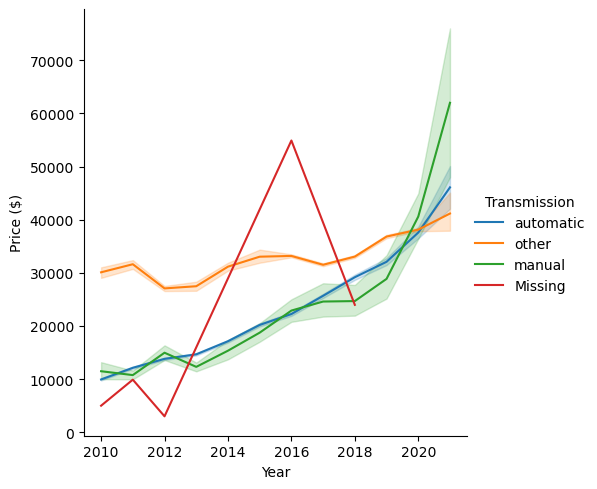

In [31]:
sns.relplot(x='year',
            y='Price ($)',
            data=data_copy,
            kind='line',
            hue='Transmission')
plt.ylabel("Price ($)")
plt.xlabel("Year")
plt.show();

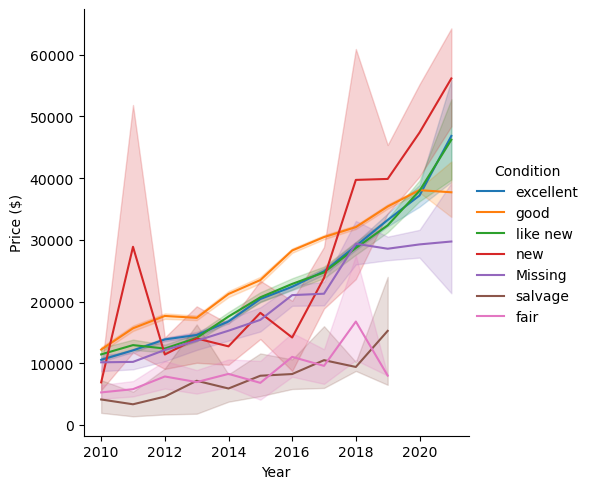

In [32]:
sns.relplot(x='year',
            y='Price ($)',
            data=data_copy,
            kind='line',
            hue='Condition')
plt.ylabel("Price ($)")
plt.xlabel("Year")
plt.show();

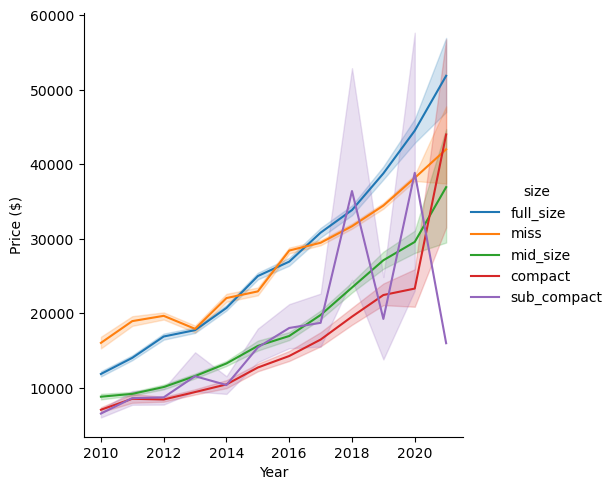

In [33]:
sns.relplot(x='year',
            y='Price ($)',
            data=data_copy,
            kind='line',
            hue='size')
plt.ylabel("Price ($)")
plt.xlabel("Year")
plt.show();

#### Heat maps

In [34]:
print(list(df.columns))
num_cols = list(df.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
print(num_cols)

['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color', 'image_url', 'description', 'state', 'lat', 'long', 'transmission_miss', 'drive_miss', 'condition_miss', 'cylinders_miss', 'fuel_miss', 'manufacturer_miss', 'model_miss', 'type_miss', 'paint_color_miss', 'posting_Year', 'posting_Month', 'posting_Week', 'posting_Day', 'posting_Dayofweek', 'posting_Dayofyear', 'posting_Is_month_end', 'posting_Is_month_start', 'posting_Is_quarter_end', 'posting_Is_quarter_start', 'posting_Is_year_end', 'posting_Is_year_start', 'posting_Hour', 'posting_Minute', 'posting_Second', 'posting_Elapsed', 'log_odometer']
['id', 'price', 'year', 'odometer', 'lat', 'long', 'transmission_miss', 'drive_miss', 'condition_miss', 'cylinders_miss', 'fuel_miss', 'manufacturer_miss', 'model_miss', 'type_miss', 'paint_color_miss', 'posting_Year', 'posting_Month', 'posting_W

In [35]:
cat_cols = list(df.select_dtypes(include=['object']))
for name in cat_cols:
    print(f"The number of unique classes for {name} is {df.loc[:,name].nunique()}")
    if df.loc[:,name].nunique() < 15:
        print(f"The classes are {df.loc[:,name].unique()}")

The number of unique classes for url is 65524
The number of unique classes for region is 402
The number of unique classes for region_url is 412
The number of unique classes for manufacturer is 41
The number of unique classes for model is 6390
The number of unique classes for condition is 7
The classes are ['excellent' 'good' 'like new' 'new' 'Missing' 'salvage' 'fair']
The number of unique classes for cylinders is 9
The classes are ['6_cylinders' '8_cylinders' '4_cylinders' '5_cylinders' '10_cylinders'
 'Missing' '3_cylinders' 'other' '12_cylinders']
The number of unique classes for fuel is 5
The classes are ['gas' 'other' 'hybrid' 'diesel' 'electric']
The number of unique classes for title_status is 6
The classes are ['clean' 'rebuilt' 'salvage' 'lien' 'missing' 'parts only']
The number of unique classes for transmission is 4
The classes are ['automatic' 'other' 'manual' 'Missing']
The number of unique classes for VIN is 21796
The number of unique classes for drive is 4
The classes ar

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


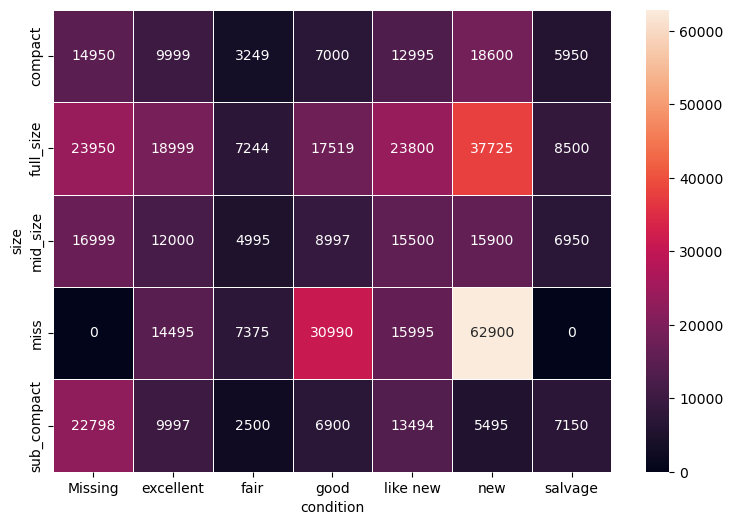

In [36]:
data_a = df.groupby(['size','condition'])['price'].median()
data_a = data_a.reset_index()
data_a = data_a.pivot("size", "condition", "price")
data_a.head()

for i in range(data_a.shape[1]):
    data_a.iloc[:,i] = data_a.iloc[:,i].fillna(0)
    data_a.iloc[:,i] = data_a.iloc[:,i].astype(int)

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_a, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.show();

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


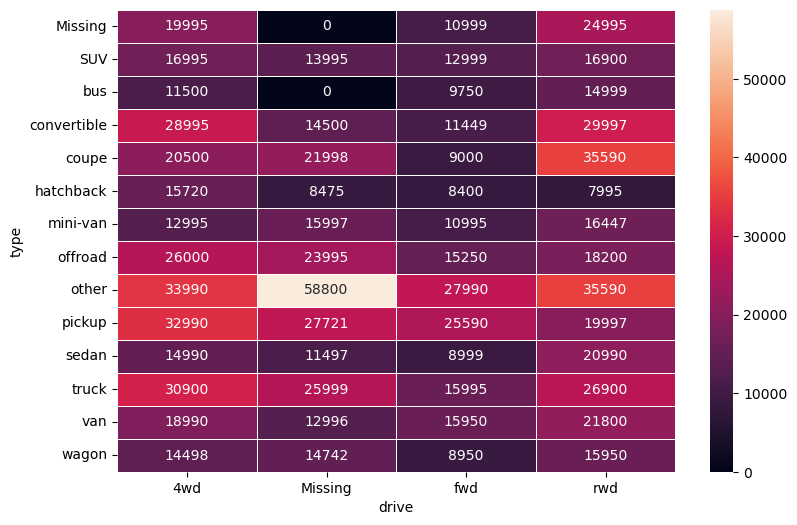

In [37]:
data_a = df.groupby(['type','drive'])['price'].median()
data_a = data_a.reset_index()
data_a = data_a.pivot("type", "drive", "price")
data_a.head()

for i in range(data_a.shape[1]):
    data_a.iloc[:,i] = data_a.iloc[:,i].fillna(0)
    data_a.iloc[:,i] = data_a.iloc[:,i].astype(int)

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_a, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.show();

In [38]:
# odometer year transmission condition size cylinders drive posting type

#### Compare plot

In [39]:
data_b = df.groupby(['fuel','type'])['price'].median()
data_b = data_b.reset_index()
data_c = data_b
data_c = data_c.pivot("type", "fuel", "price")
data_c = data_c.reset_index()
data_c = data_c.sort_values("type", ascending=True)
for name in ['gas','other','hybrid','diesel','electric']:
    data_c.loc[:,name] = data_c.loc[:,name].fillna(0)
    data_c.loc[:,name] = data_c.loc[:,name].astype(int)


In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


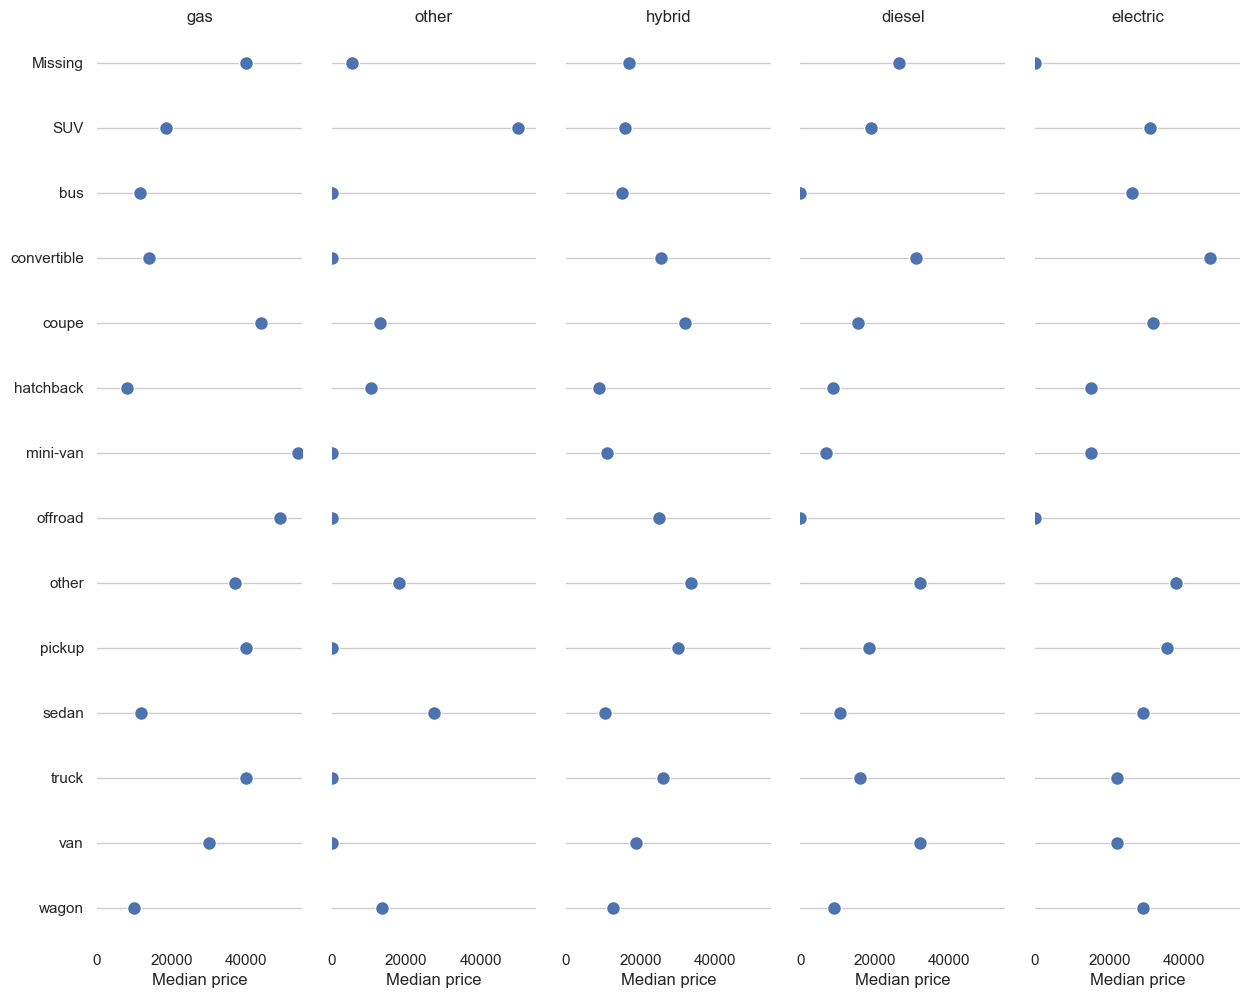

In [40]:
sns.set_theme(style="whitegrid")

# Make the PairGrid
g = sns.PairGrid(data_c,
                 x_vars=data_c.columns[1:], y_vars=["type"],
                 height=10, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, max(data_c.max(axis = 1)) + 1000), xlabel="Median price", ylabel="")

# Use semantically meaningful titles for the columns
titles = ['gas','other','hybrid','diesel','electric']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

### New features

In [41]:
#     log_odometer              1.921831
#     year                      0.483297
#     transmission_other        0.335848
#     transmission_automatic    0.275912
#     size_miss                 0.261420
#     condition_good            0.252833

In [42]:
#odometer year transmission condition size cylinders drive posting type

df['log_odometer'] = np.log(df['odometer'])

for name in ['feature_1','feature_2','feature_3','feature_4','feature_5']:
    df[name] = 0
df.loc[((df['log_odometer'] < 6) & (df.year <= 2014)),'feature_1'] = 1
df.loc[(df.log_odometer < 10) & (df.year >= 2018) & (df.condition == 'new'),'feature_2'] = 1
df.loc[(df.log_odometer < 10) & (df.year >= 2018) & (df.cylinders == '8_cylinders'),'feature_3'] = 1
df.loc[(df.drive == 'fwd') & (df.year <= 2014),'feature_4'] = 1
df.loc[(df.transmission == 'other') & (df.year <= 2015),'feature_5'] = 1

In [43]:
#pd.crosstab(df['feature_1'], columns = 'Count')
#pd.crosstab(df.log_odometer < 6, df.feature_1)
for name in ['feature_1','feature_2','feature_3','feature_4']:
    print(name, df[df[name] == 1].shape[0])

feature_1 92
feature_2 163
feature_3 1871
feature_4 12898


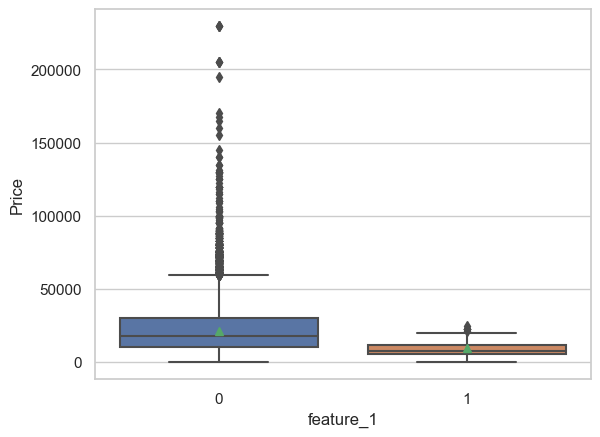

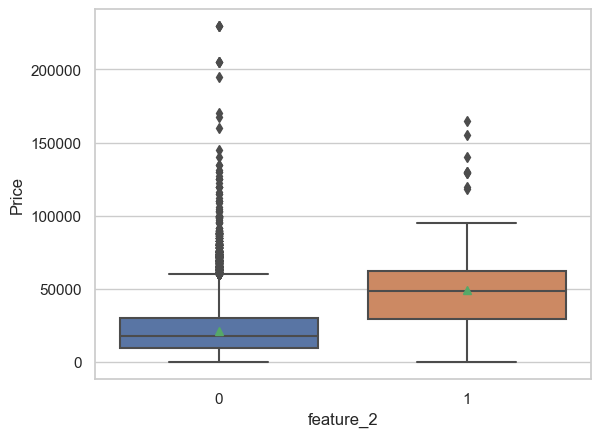

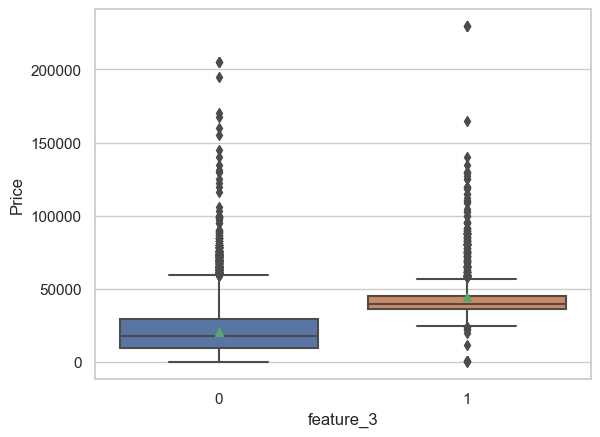

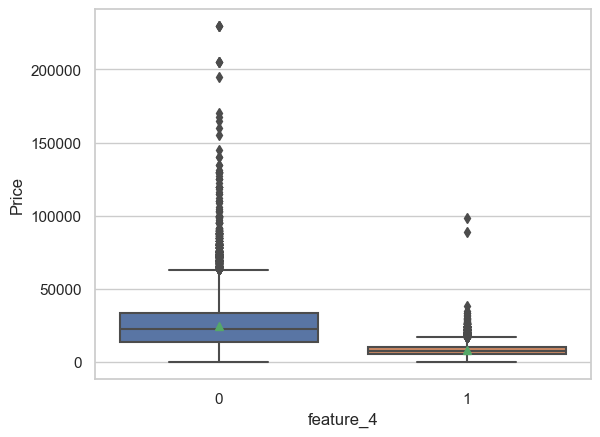

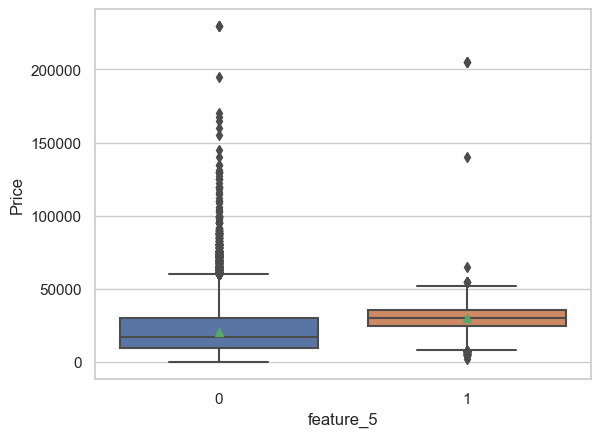

In [44]:
for name in [col for col in df.columns if 'feature_' in col]:
    
    sns.boxplot(data=df, x=name, y="price", showmeans = True)
    plt.ylabel("Price")
    plt.show();
    
    

### Prediction

In [45]:
mod_data = df.drop(['VIN','long','lat','id','posting_Elapsed',
                    'url', 'region_url', 'image_url', 'description','odometer'], axis = 1)
#for name in ['remote_ratio']:
#    mod_data[name] = mod_data[name].astype(str)
#mod_data = mod_data[mod_data.employment_type == 'FT']
try:
    mod_data = mod_data.drop(['row_miss'], axis=1)
except:
    mod_data = mod_data

y = mod_data.price
X = mod_data.drop(['price'], axis = 1)

#### Test-Train split

In [46]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

skf = StratifiedKFold(n_splits = 5)
skf.get_n_splits(X, y)

for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)    

The least populated class in y has only 1 members, which is less than n_splits=5.


TRAIN: [   60    73    99 ... 65521 65522 65523] TEST: [    0     1     2 ... 65247 65258 65273]
TRAIN: [    0     1     2 ... 65521 65522 65523] TEST: [   60   100   101 ... 65330 65331 65356]
TRAIN: [    0     1     2 ... 65521 65522 65523] TEST: [   73   151   153 ... 65353 65357 65359]
TRAIN: [    0     1     2 ... 65521 65522 65523] TEST: [   99   158   172 ... 65347 65392 65466]
TRAIN: [    0     1     2 ... 65359 65392 65466] TEST: [  150   236   538 ... 65521 65522 65523]
(52420, 44) (13104, 44) (52420,) (13104,)


#### Numeric data

In [47]:
#########################################
### Check for single non varying data ###
#########################################

lst = []
for name in list(X_train.columns):
    if (X_train[name].nunique() == 1):
        lst.append(name)

print(lst)

['fuel_miss', 'posting_Year', 'posting_Is_quarter_end', 'posting_Is_quarter_start', 'posting_Is_year_end', 'posting_Is_year_start']


In [48]:
try:
    X_train = X_train.drop(lst, axis=1)
    X_test = X_test.drop(lst, axis=1)
except:
    X_train = X_train
    X_test = X_test

In [49]:
#########################
### Multicollinearity ###
#########################

num_cols = X_train.select_dtypes(include=np.number).columns.tolist()

vif = calculate_vif(X_train[num_cols])

a = vif[(vif.VIF > 10)]
to_drop_vif = list(a.Features)
print(to_drop_vif)
        


divide by zero encountered in double_scalars


['posting_Month', 'posting_Week', 'posting_Day', 'posting_Dayofweek', 'posting_Dayofyear']


In [50]:
#pd.crosstab(X_train.posting_Year, columns = 'Count')

In [51]:
try:
    X_train = X_train.drop(to_drop_vif, axis=1)
    X_test = X_test.drop(to_drop_vif, axis=1)
except:
    X_train = X_train
    X_test = X_test

In [52]:
num_cols = list(X_train.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if '_miss' in col])))
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if 'feature_' in col])))
sns.pairplot(X_train[num_cols])
plt.show();

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[]


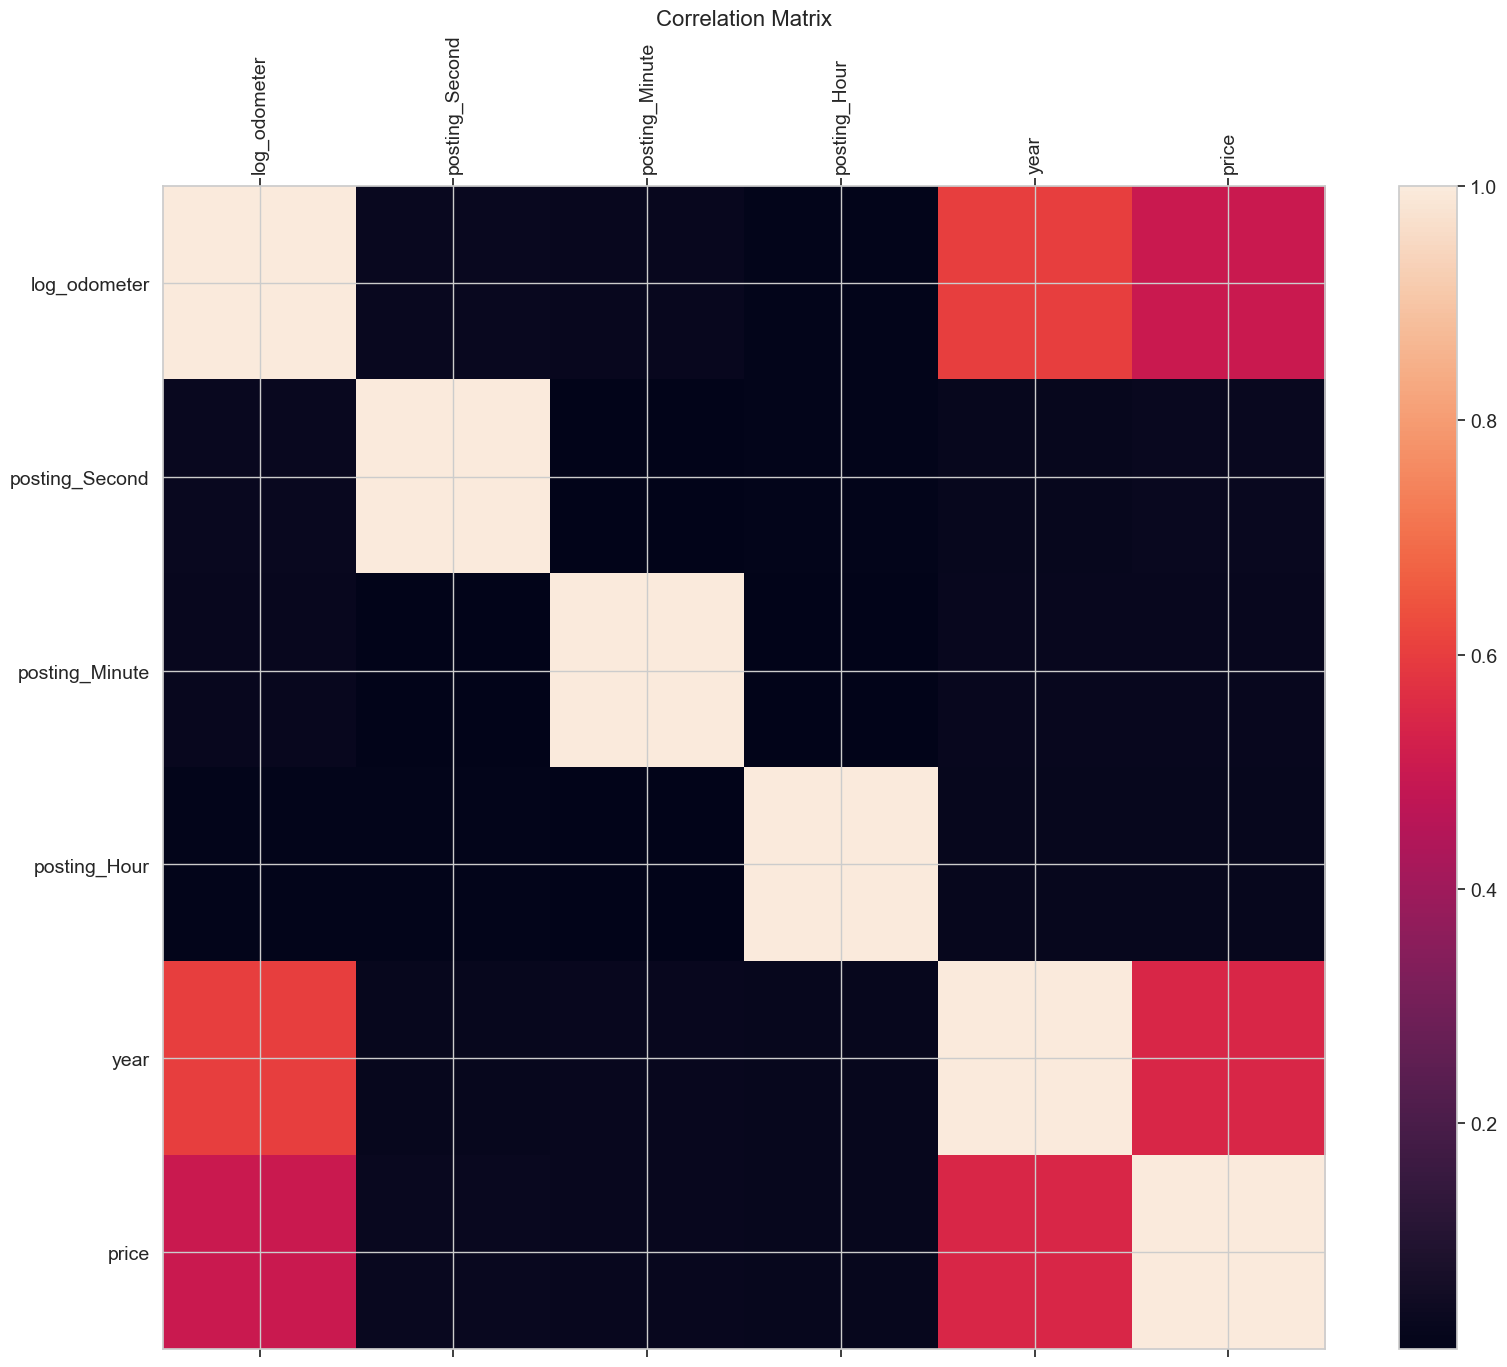

In [53]:
###################
### Correlation ###
###################

num_cols = list(X_train.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if '_miss' in col])))
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if 'feature_' in col])))

corre_data = pd.concat([X_train[num_cols],
                        pd.DataFrame(y_train)],
                       axis = 1)

cor_matrix = corre_data.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
print(to_drop)

f = plt.figure(figsize=(19, 15))
plt.matshow(cor_matrix, fignum=f.number)
plt.xticks(range(corre_data.select_dtypes(['number']).shape[1]),
           corre_data.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(corre_data.select_dtypes(['number']).shape[1]),
           corre_data.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show();

In [54]:
#####################
### MinMax scaler ###
#####################

num_cols = list(X_train.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if '_miss' in col])))
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if 'feature_' in col])))

print(X_train[num_cols].shape)

transformer_train = MinMaxScaler().fit(X_train[num_cols])
num_data_train = pd.DataFrame(transformer_train.transform(X_train[num_cols]))
num_data_train.columns = num_cols
print(num_data_train.shape)

num_data_test = minmax_dset(X_test,num_cols) ### Test ###

(52420, 5)
(52420, 5)
(13104, 5)


#### Categorical data

In [55]:
###################################
### High cardinality adjustment ###
###################################

cat_cols = list(X_train.select_dtypes(include=['object']))

card_vars = []
cat_data = X_train[cat_cols]
for i in range(cat_data.shape[1]):
    X_train.loc[X_train[cat_data.columns[i]].isnull(),cat_data.columns[i]] = 'Missing'
    X_test.loc[X_test[cat_data.columns[i]].isnull(),cat_data.columns[i]] = 'Missing'

    if (cat_data.iloc[:,i].nunique() > 60): 
        print(cat_data.columns[i],len(list(set(cat_data.iloc[:,i]))))

        a = pd.crosstab(cat_data[cat_data.columns[i]],columns='Count')
        a = pd.DataFrame(a).sort_values('Count',ascending=False).reset_index()
        val_list = list(a.iloc[:20,0])
        X_train.loc[~X_train[cat_data.columns[i]].isin(val_list),cat_data.columns[i]] = 'Other'
        X_test.loc[~X_test[cat_data.columns[i]].isin(val_list),cat_data.columns[i]] = 'Other'

    if (len(list(set(cat_data.iloc[:,i]))) > 100):
        card_vars.append(cat_data.columns[i])

print(card_vars)

region 389
model 5669
['region', 'model']


In [56]:
#pd.crosstab(X_train.description, columns = 'Count')

In [57]:
########################
### One hot encoding ###
########################

ohe = OneHotEncoder()
print(X_train.shape)
# (1808, 10)

### Train ###

ohe.fit(X_train[cat_cols])
colnames = ohe.get_feature_names_out(cat_cols)

cat_data_train = ohe_dset(X_train,cat_cols)  ### Train ###
cat_data_test = ohe_dset(X_test,cat_cols)    ### Test ###

(52420, 33)
(52420, 200)
(13104, 196)


In [58]:
bin_data_cols = [col for col in X_train.columns if '_miss' in col] + [col for col in X_train.columns if 'feature_' in col]
bin_data_train = X_train[bin_data_cols]
bin_data_test = X_test[bin_data_cols]
print(bin_data_cols)
print(bin_data_train.shape)

['transmission_miss', 'drive_miss', 'condition_miss', 'cylinders_miss', 'manufacturer_miss', 'model_miss', 'type_miss', 'paint_color_miss', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']
(52420, 13)


In [59]:
print(list(cat_data_train.columns))
print(list(num_data_train.columns))
print(list(bin_data_train.columns))



['region_Other', 'region_albany', 'region_anchorage_mat_su', 'region_boston', 'region_central_NJ', 'region_columbus', 'region_detroit_metro', 'region_ft_myers_SW_florida', 'region_grand_rapids', 'region_indianapolis', 'region_jacksonville', 'region_kansas_city_MO', 'region_louisville', 'region_minneapolis_st_paul', 'region_oklahoma_city', 'region_omaha_council_bluffs', 'region_phoenix', 'region_rochester', 'region_san_diego', 'region_st_louis_MO', 'region_stockton', 'manufacturer_Missing', 'manufacturer_acura', 'manufacturer_alfa_romeo', 'manufacturer_aston_martin', 'manufacturer_audi', 'manufacturer_bmw', 'manufacturer_buick', 'manufacturer_cadillac', 'manufacturer_chevrolet', 'manufacturer_chrysler', 'manufacturer_dodge', 'manufacturer_ferrari', 'manufacturer_fiat', 'manufacturer_ford', 'manufacturer_gmc', 'manufacturer_harley_davidson', 'manufacturer_honda', 'manufacturer_hyundai', 'manufacturer_infiniti', 'manufacturer_jaguar', 'manufacturer_jeep', 'manufacturer_kia', 'manufacturer

In [60]:
###########################
### Bring data together ###
###########################

print(cat_data_train.shape, num_data_train.shape, bin_data_train.shape)
cat_data_train = cat_data_train.reset_index()
num_data_train = num_data_train.reset_index()
bin_data_train = bin_data_train.reset_index()

X_train = pd.concat([cat_data_train,num_data_train],axis = 1)
print(X_train.shape)
X_train = pd.concat([X_train,bin_data_train],axis = 1)
print(X_train.shape)

print(cat_data_test.shape, num_data_test.shape, bin_data_test.shape)
cat_data_test = cat_data_test.reset_index()
num_data_test = num_data_test.reset_index()
bin_data_test = bin_data_test.reset_index()
X_test = pd.concat([cat_data_test,num_data_test],axis = 1)
X_test = pd.concat([X_test,bin_data_test],axis = 1)

print(X_train.shape, X_test.shape)

# (64215, 105) (42811, 103) (10148, 89)

(52420, 200) (52420, 5) (52420, 13)
(52420, 207)
(52420, 221)
(13104, 196) (13104, 5) (13104, 13)
(52420, 221) (13104, 217)


In [61]:
####################################################
### Check that train/test sets have same columns ###
####################################################

mod_cols = (list(set(list(X_train.columns)) - set(['index'])))
X_train = X_train[mod_cols]
miss_lst = list(set(list(X_train.columns)) - set(list(X_test.columns)))

for name in miss_lst:
    X_test[name] = 0
X_test = X_test[list(X_train.columns)]

drop_test_lst = list(set(list(X_test.columns)) - set(list(X_train.columns)))
X_test = X_test.drop(drop_test_lst, axis = 1)

print(X_train.shape, X_test.shape)
# (64215, 105) (42811, 135) (10148, 107)

(52420, 218) (13104, 218)


#### Mutual information check

In [62]:
mutual_info = mutual_info_regression(X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns

In [63]:
mutual_info = mutual_info.sort_values(ascending=False)
mutual_info[:20]

log_odometer              2.134499
year                      0.499191
transmission_other        0.341125
transmission_automatic    0.274126
size_miss                 0.262348
condition_good            0.260577
feature_4                 0.221739
cylinders_4_cylinders     0.209947
drive_fwd                 0.197465
posting_Minute            0.197342
posting_Hour              0.187346
condition_excellent       0.174942
cylinders_8_cylinders     0.151670
size_full_size            0.146996
drive_4wd                 0.131785
type_sedan                0.120698
type_truck                0.110308
type_pickup               0.102562
size_mid_size             0.089051
drive_rwd                 0.084365
dtype: float64

<Axes: >

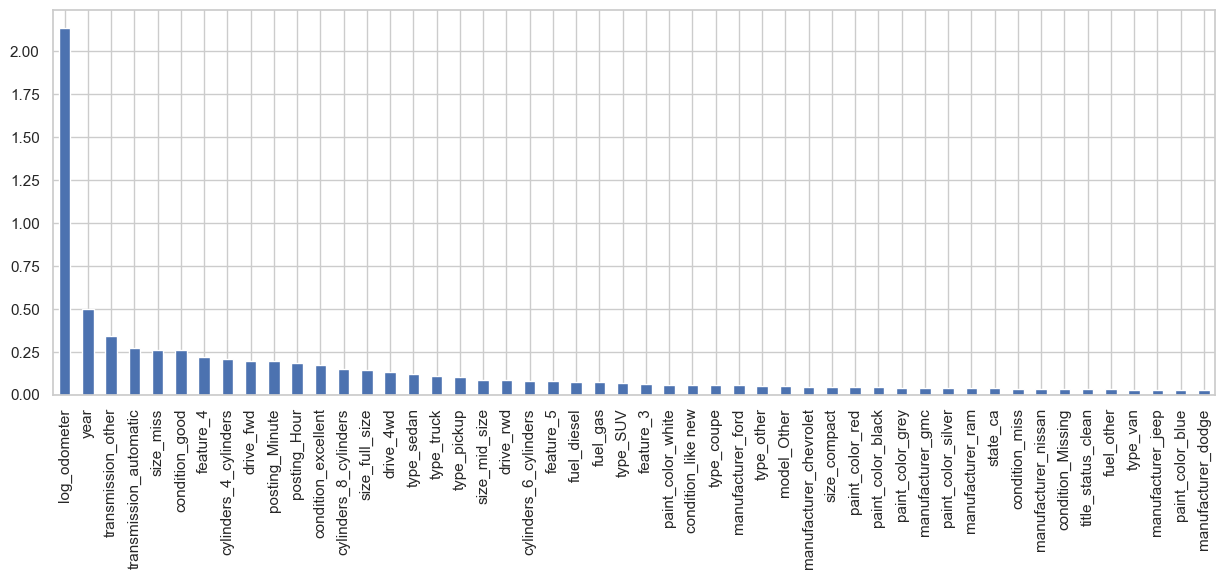

In [64]:
mutual_info[:50].sort_values(ascending=False).plot.bar(figsize=(15,5))
plt.show()

In [65]:
X_train_red = X_train[list(mutual_info[:50].index)]
X_test_red = X_test[list(mutual_info[:50].index)]
print(X_train_red.shape, X_test_red.shape)

(52420, 50) (13104, 50)


### Models

#### Gradient Boosting Regressor

In [227]:
gbr = GradientBoostingRegressor(random_state=0)

2 hours to run

In [231]:
gbr_param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4]
    #'max_features': ['auto', 'sqrt', 'log2']
}

# create gridseatchobject
gbr_gridsearch = GridSearchCV(gbr, gbr_param_grid, cv=3, verbose = 2)

# fit gridsearch
gbr_gridsearch.fit(X_train_red, y_train)

# print best params and validaton score
print("Best parameters: ", gbr_gridsearch.best_params_)
print("Cross Validation Score: ", gbr_gridsearch.best_score_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.5s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.5s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  10.4s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total t

[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   8.8s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   8.9s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   8.9s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=4, min_samples_split=8, n_estimators=50; total time=   2.3s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=4, min_samples_split=8, n_estimators=50; total time=   2.3s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=4, min_samples_split=8, n_estimators=50; total time=   2.3s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100; total time=   4.4s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100; total time=   4.5s
[CV] END learning_rate=0.1, max_depth=3, min_sample

[CV] END learning_rate=0.1, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   7.4s
[CV] END learning_rate=0.1, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   7.4s
[CV] END learning_rate=0.1, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=  14.5s
[CV] END learning_rate=0.1, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=  14.7s
[CV] END learning_rate=0.1, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=  14.6s
[CV] END learning_rate=0.1, max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   3.8s
[CV] END learning_rate=0.1, max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   3.7s
[CV] END learning_rate=0.1, max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   4.2s
[CV] END learning_rate=0.1, max_depth=5, min_sample

[CV] END learning_rate=0.1, max_depth=7, min_samples_leaf=2, min_samples_split=8, n_estimators=50; total time=   5.5s
[CV] END learning_rate=0.1, max_depth=7, min_samples_leaf=2, min_samples_split=8, n_estimators=100; total time=  10.4s
[CV] END learning_rate=0.1, max_depth=7, min_samples_leaf=2, min_samples_split=8, n_estimators=100; total time=  10.8s
[CV] END learning_rate=0.1, max_depth=7, min_samples_leaf=2, min_samples_split=8, n_estimators=100; total time=  10.6s
[CV] END learning_rate=0.1, max_depth=7, min_samples_leaf=2, min_samples_split=8, n_estimators=200; total time=  21.3s
[CV] END learning_rate=0.1, max_depth=7, min_samples_leaf=2, min_samples_split=8, n_estimators=200; total time=  21.5s
[CV] END learning_rate=0.1, max_depth=7, min_samples_leaf=2, min_samples_split=8, n_estimators=200; total time=  21.7s
[CV] END learning_rate=0.1, max_depth=7, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   5.4s
[CV] END learning_rate=0.1, max_depth=7, min_sampl

[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   9.0s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   2.3s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   2.2s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   2.2s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   4.6s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   4.7s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   4.8s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   9.7s
[CV] END learning_rate=0.05, max_depth=3, m

[CV] END learning_rate=0.05, max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=100; total time=   7.8s
[CV] END learning_rate=0.05, max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=200; total time=  15.4s
[CV] END learning_rate=0.05, max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=200; total time=  15.4s
[CV] END learning_rate=0.05, max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=200; total time=  15.5s
[CV] END learning_rate=0.05, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   3.9s
[CV] END learning_rate=0.05, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   4.0s
[CV] END learning_rate=0.05, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   4.1s
[CV] END learning_rate=0.05, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   7.9s
[CV] END learning_rate=0.05, max_depth=5, m

[CV] END learning_rate=0.05, max_depth=7, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   5.4s
[CV] END learning_rate=0.05, max_depth=7, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=  10.5s
[CV] END learning_rate=0.05, max_depth=7, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=  10.1s
[CV] END learning_rate=0.05, max_depth=7, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=  10.9s
[CV] END learning_rate=0.05, max_depth=7, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=  20.6s
[CV] END learning_rate=0.05, max_depth=7, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=  20.4s
[CV] END learning_rate=0.05, max_depth=7, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=  20.4s
[CV] END learning_rate=0.05, max_depth=7, min_samples_leaf=1, min_samples_split=8, n_estimators=50; total time=   5.1s
[CV] END learning_rate=0.05, max_depth=7, 

[CV] END learning_rate=0.05, max_depth=7, min_samples_leaf=4, min_samples_split=8, n_estimators=200; total time=  21.5s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.9s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   9.5s
[CV] END learning_rate=0.01, max_depth=3, m

[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   4.8s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   9.6s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   9.5s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   9.8s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=4, min_samples_split=8, n_estimators=50; total time=   2.5s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=4, min_samples_split=8, n_estimators=50; total time=   2.5s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=4, min_samples_split=8, n_estimators=50; total time=   2.5s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100; total time=   4.8s
[CV] END learning_rate=0.01, max_depth=3, m

[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.7s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   7.5s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   7.4s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   7.3s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=  15.1s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=  15.6s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=  16.1s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   3.9s
[CV] END learning_rate=0.01, max_depth=5, 

[CV] END learning_rate=0.01, max_depth=7, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=  21.0s
[CV] END learning_rate=0.01, max_depth=7, min_samples_leaf=2, min_samples_split=8, n_estimators=50; total time=   5.3s
[CV] END learning_rate=0.01, max_depth=7, min_samples_leaf=2, min_samples_split=8, n_estimators=50; total time=   5.5s
[CV] END learning_rate=0.01, max_depth=7, min_samples_leaf=2, min_samples_split=8, n_estimators=50; total time=   5.2s
[CV] END learning_rate=0.01, max_depth=7, min_samples_leaf=2, min_samples_split=8, n_estimators=100; total time=  10.9s
[CV] END learning_rate=0.01, max_depth=7, min_samples_leaf=2, min_samples_split=8, n_estimators=100; total time=  10.9s
[CV] END learning_rate=0.01, max_depth=7, min_samples_leaf=2, min_samples_split=8, n_estimators=100; total time=  11.0s
[CV] END learning_rate=0.01, max_depth=7, min_samples_leaf=2, min_samples_split=8, n_estimators=200; total time=  21.3s
[CV] END learning_rate=0.01, max_depth=7, m

Best parameters:  {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}  
Cross Validation Score:  0.8391718131396271

In [274]:
GradientBoostingRegressor().get_params().keys()

dict_keys(['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [233]:
gbr_hyp = GradientBoostingRegressor(random_state=0,
                                    learning_rate = gbr_gridsearch.best_params_['learning_rate'],
                                    n_estimators = gbr_gridsearch.best_params_['n_estimators'],
                                    max_depth = gbr_gridsearch.best_params_['max_depth'],
                                    min_samples_split = gbr_gridsearch.best_params_['min_samples_split'],
                                    min_samples_leaf = gbr_gridsearch.best_params_['min_samples_leaf'])

In [235]:
gbr_valid_score = gbr_gridsearch.score(X_test_red, y_test)

print("Validation Score: ", gbr_valid_score)

Validation Score:  0.848525421610389


In [237]:
gbr_hyp.fit(X_train_red, y_train)

y_pred_gbr = gbr_hyp.predict(X_test_red)

gbr_mae = mean_absolute_error(y_test, y_pred_gbr)
print("MAE: ", gbr_mae)

MAE:  3050.9394562006732


In [238]:
gbr_rmse = mean_squared_error(y_test, y_pred_gbr, squared=False)
print("RMSE: ", gbr_rmse)

RMSE:  5326.591983837553


In [239]:
print("R2 score: ", r2_score(y_test, y_pred_gbr))

R2 score:  0.848525421610389


#### Adaboost Regressor

In [273]:
from sklearn.ensemble import AdaBoostRegressor

abr = AdaBoostRegressor()

abr_param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [50, 100, 200],
    'loss' : ['linear', 'square', 'exponential']
}

# create gridseatchobject
abr_gridsearch = GridSearchCV(abr, abr_param_grid, cv = 3, verbose = 2)

# fit gridsearch
abr_gridsearch.fit(X_train_red, y_train)

# print best params and validaton score
print("Best parameters: ", abr_gridsearch.best_params_)
print("Cross Validation Score: ", abr_gridsearch.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ....learning_rate=0.1, loss=linear, n_estimators=50; total time=   6.0s
[CV] END ....learning_rate=0.1, loss=linear, n_estimators=50; total time=   6.1s
[CV] END ....learning_rate=0.1, loss=linear, n_estimators=50; total time=   5.9s
[CV] END ...learning_rate=0.1, loss=linear, n_estimators=100; total time=  12.2s
[CV] END ...learning_rate=0.1, loss=linear, n_estimators=100; total time=  11.9s
[CV] END ...learning_rate=0.1, loss=linear, n_estimators=100; total time=  12.2s
[CV] END ...learning_rate=0.1, loss=linear, n_estimators=200; total time=  23.5s
[CV] END ...learning_rate=0.1, loss=linear, n_estimators=200; total time=  24.2s
[CV] END ...learning_rate=0.1, loss=linear, n_estimators=200; total time=  22.0s
[CV] END ....learning_rate=0.1, loss=square, n_estimators=50; total time=   5.8s
[CV] END ....learning_rate=0.1, loss=square, n_estimators=50; total time=   5.9s
[CV] END ....learning_rate=0.1, loss=square, n_e

Best parameters:  {'learning_rate': 0.05, 'loss': 'exponential', 'n_estimators': 100}  
Cross Validation Score:  0.5837327010234632

In [272]:
AdaBoostRegressor().get_params().keys()

dict_keys(['base_estimator', 'learning_rate', 'loss', 'n_estimators', 'random_state'])

In [278]:
abr_hyp = AdaBoostRegressor(random_state=0,
                            learning_rate = abr_gridsearch.best_params_['learning_rate'],
                            n_estimators = abr_gridsearch.best_params_['n_estimators'],
                            loss = abr_gridsearch.best_params_['loss'])

In [279]:
abr_valid_score = abr_gridsearch.score(X_test_red, y_test)

print("Validation Score: ", abr_valid_score)

Validation Score:  0.5872103026614861


In [280]:
abr_hyp.fit(X_train_red, y_train)

y_pred_abr = abr_hyp.predict(X_test_red)

abr_mae = mean_absolute_error(y_test, y_pred_abr)
print("MAE: ", abr_mae)

6226.218832640497

In [281]:
abr_rmse = mean_squared_error(y_test, y_pred_abr, squared=False)
print("RMSE: ", abr_rmse)

RMSE:  8851.987911743532


In [282]:
print("R2 score: ", r2_score(y_test, y_pred_abr))

R2 score:  0.5918366491275074


#### Light GBM Regressor

In [73]:
lgb = lg.LGBMRegressor()

lgb_param_grid = {
    'num_leaves' : [60, 100, 140, 200],
    'min_data_in_leaf': [50, 100, 500],
    'max_bin' : [200, 300, 500],
    'learning_rate': [0.2, 0.1, 0.01, 0.001],
    'max_depth': [5, 7, 9, 11],    
    'n_estimators': [100, 200, 400, 600]    
}

# create gridseatchobject
lgb_gridsearch = GridSearchCV(lgb, lgb_param_grid, cv = 5, verbose = 2)

# fit gridsearch
lgb_gridsearch.fit(X_train_red, y_train)

# print best params and validaton score
print("Best parameters: ", lgb_gridsearch.best_params_)
print("Cross Validation Score: ", lgb_gridsearch.best_score_)

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min

[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=100, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=100, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_l

[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_

[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; 

[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value

[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=400, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=400, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=400, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value

[CV] END learning_rate=0.1, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_

[CV] END learning_rate=0.1, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=50, num_leaves=140; total time=

[CV] END learning_rate=0.1, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_l

[CV] END learning_rate=0.1, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=140; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=200; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=200; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.1, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value

[CV] END learning_rate=0.1, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=400, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=400, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=400, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: m

[CV] END learning_rate=0.1, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_l

[CV] END learning_rate=0.1, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.1, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_l

[CV] END learning_rate=0.1, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.1, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=400, num_leaves=100; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=400, num_leaves=100; total time=   1.9s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=400, num_leaves=100; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_i

[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=100, num_leaves=60;

[CV] END learning_rate=0.1, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=200, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=200, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=200, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value

[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=50, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf

[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   1.1s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   1.1s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=140; total time=   1.1s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=140; total time=   1.1s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_l

[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: mi

[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=200, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=200, num_leaves=60; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=200, num_leaves=60; total time=   1.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=200, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: mi

[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=140; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=140; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=200; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=200; total time=   1.9s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value

[CV] END learning_rate=0.1, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.1, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=400, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=400, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=400, num_leaves=60; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=50, num_leaves=200; total time=

[CV] END learning_rate=0.1, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=200, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=200, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=200, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_i

[CV] END learning_rate=0.1, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=400, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=400, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=400, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_dat

[CV] END learning_rate=0.1, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value

[CV] END learning_rate=0.1, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=400, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=400, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: 

[CV] END learning_rate=0.1, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=50, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_l

[CV] END learning_rate=0.1, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.1, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf

[CV] END learning_rate=0.1, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=100, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=100, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.1, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=100; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=100; total time=   1.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=140; total time=   1.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_

[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=100, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=100, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=100, num_leaves=60;

[CV] END learning_rate=0.1, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=200, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=200, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value

[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_l

[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=100, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=200, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=200, num_leaves=60; total time=   1.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=200, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_

[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=400, num_leaves=140; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=400, num_leaves=140; total time=   1.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=400, num_leaves=140; total time=   1.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   1.0s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=200, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=200, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in

[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=50, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=50, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=50, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: mi

[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=200, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value:

[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=400, num_leaves=200; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=400, num_leaves=200; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=400, num_leaves=200; total time=   1.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_

[CV] END learning_rate=0.1, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.1, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=60; total time=   1.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=60; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   1.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   1.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in

[CV] END learning_rate=0.1, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=50, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=50, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=50, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_l

[CV] END learning_rate=0.1, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.1, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.1, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value

[CV] END learning_rate=0.1, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=140; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=140; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value

[CV] END learning_rate=0.1, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_l

[CV] END learning_rate=0.1, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=200, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=50, num_leaves=140; total time=

[CV] END learning_rate=0.1, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_

[CV] END learning_rate=0.1, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=400, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=400, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=400, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=400, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_

[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=

[CV] END learning_rate=0.1, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=400, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value:

[CV] END learning_rate=0.1, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_l

[CV] END learning_rate=0.1, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in

[CV] END learning_rate=0.1, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.1, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.1, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=100; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_

[CV] END learning_rate=0.1, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: mi

[CV] END learning_rate=0.1, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=200, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=200, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value

[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=

[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=100, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=100, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=100, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   1.0s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   1.1s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=400, num_leaves=140; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_l

[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=200, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=200, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: mi

[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=200, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=200, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=200, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: m

[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=400, num_leaves=140; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=400, num_leaves=140; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=400, num_leaves=140; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=400, num_leaves=200; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value

[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=100; total time=   1.0s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=100; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=100; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=100; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=60; total time=   1.1s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=60; total time=   1.0s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in

[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=50, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=50, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=50, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=50, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_l

[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=100; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_i

[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=400, num_leaves=200; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=400, num_leaves=200; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=400, num_leaves=200; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_dat

[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value

[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.1, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: 

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=50, num_leaves=200; total t

[CV] END learning_rate=0.05, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=200, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=200, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.05, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_l

[CV] END learning_rate=0.05, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=100, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=100, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.05, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=400, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=400, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=400, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=400, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.05, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value

[CV] END learning_rate=0.05, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=200, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=200, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=200, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current v

[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=50, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_i

[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=100, num_leaves=200; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=100, num_leaves=200; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=100, num_leaves=200; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_da

[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=400, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=400, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=400, num_leaves=140; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=400, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_dat

[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=200, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=200, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=200, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=200, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=50, num_leaves=

[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=200, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=200, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=200, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current valu

[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=400, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=400, num_leaves=200; total time=   1.0s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=400, num_leaves=200; total time=   1.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=400, num_leaves=200; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current v

[CV] END learning_rate=0.05, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=100, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=100, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=100, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.05, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=400, num_leaves=60; total time=   1.9s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=400, num_leaves=60; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=400, num_leaves=60; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=400, num_leaves=60; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.05, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.05, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=200, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=200, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=200, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=200, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.05, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=400, num_leaves=200; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: m

[CV] END learning_rate=0.05, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current v

[CV] END learning_rate=0.05, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=400, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=400, num_leaves=60; total time=   1.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current val

[CV] END learning_rate=0.05, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=50, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=50, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=50, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=50, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.05, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=200, num_leaves=140; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=200, num_leaves=140; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=200, num_leaves=140; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.05, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=50, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=50, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=50, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=50, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_

[CV] END learning_rate=0.05, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=100, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=100, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=100, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=100, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.05, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=400, num_leaves=100; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=400, num_leaves=100; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=400, num_leaves=140; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=400, num_leaves=140; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.05, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value

[CV] END learning_rate=0.05, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=200, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=200, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current v

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total t

[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=200, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=200, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=200, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data

[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=400, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=400, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=400, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=100, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=100, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=100, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=100, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=200, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=200, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_dat

[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value

[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=200, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=200, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current val

[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=400, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=400, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=400, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=400, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current v

[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=400, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=400, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=400, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=400, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=200, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=200, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=200, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: mi

[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current v

[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=400, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current va

[CV] END learning_rate=0.05, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=100, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.05, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=200, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=200, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=200, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=200, num_leaves=140; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.05, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in

[CV] END learning_rate=0.05, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.05, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=400, num_leaves=100; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=400, num_leaves=140; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=400, num_leaves=140; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=400, num_leaves=140; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.05, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current valu

[CV] END learning_rate=0.05, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=200, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   2.9s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   1.0s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current v

[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=50, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=50, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=50, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=200, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=200, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=200, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=200, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=140; total time=   1.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=140; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   1.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=100, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=100, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=100, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=100, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data

[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value

[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=200, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current va

[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=200; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=200; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=200; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=200; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current va

[CV] END learning_rate=0.05, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.05, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=400, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=400, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=400, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data

[CV] END learning_rate=0.05, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=50, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.05, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=200, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=200, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=50, num_leaves=60;

[CV] END learning_rate=0.05, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current v

[CV] END learning_rate=0.05, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current v

[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_i

[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_da

[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current val

[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current v

[CV] END learning_rate=0.05, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.05, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=200, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=200, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=200, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=200, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.05, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=400, num_leaves=140; total time=   1.0s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   1.0s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   1.0s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   1.0s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.05, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.05, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.05, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value

[CV] END learning_rate=0.05, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current v

[CV] END learning_rate=0.05, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=400, num_leaves=200; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=400, num_leaves=200; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=400, num_leaves=200; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: 

[CV] END learning_rate=0.05, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   1.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.05, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=60; total time=   1.1s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=60; total time=   1.1s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.05, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_dat

[CV] END learning_rate=0.05, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=50, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=50, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=50, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=50, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.05, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=100; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.05, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.05, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: m

[CV] END learning_rate=0.05, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current v

[CV] END learning_rate=0.05, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.05, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current v

[CV] END learning_rate=0.01, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.01, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=200, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=200, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=200, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.01, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=50, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.01, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=100, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=100, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_dat

[CV] END learning_rate=0.01, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=400, num_leaves=140; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=400, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=400, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=400, num_leaves=140; total time=  41.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.01, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=  -0.1s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current va

[CV] END learning_rate=0.01, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current v

[CV] END learning_rate=0.01, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.01, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data

[CV] END learning_rate=0.01, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   1.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   1.1s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.01, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.01, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_

[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=50, num_leaves=

[CV] END learning_rate=0.01, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=200, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current v

[CV] END learning_rate=0.01, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=400, num_leaves=200; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_i

[CV] END learning_rate=0.01, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   1.0s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   1.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=100, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.01, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   1.1s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   1.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   1.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   2.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.01, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=50, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=50, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=60; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.01, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.01, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value:

[CV] END learning_rate=0.01, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current v

[CV] END learning_rate=0.01, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=400, num_leaves=140; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=400, num_leaves=140; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current v

[CV] END learning_rate=0.01, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.01, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=200, num_leaves=140; total time=   1.1s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   1.1s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   1.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.01, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=50, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=50, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=50, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=50, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.01, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.01, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=400, num_leaves=140; total time=   1.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=400, num_leaves=140; total time=   2.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=400, num_leaves=200; total time=   1.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=400, num_leaves=200; total time=   1.0s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.01, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current v

[CV] END learning_rate=0.01, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=60; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=60; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current val

[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=200, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_da

[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_dat

[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=400, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=400, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_dat

[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=50, num_leaves=

[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=200, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=200, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current v

[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_l

[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   1.0s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=200, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value

[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=200, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current va

[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=400, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=400, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=400, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current v

[CV] END learning_rate=0.01, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=100, num_leaves=60; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=100, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=100, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=100, num_leaves=100; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data

[CV] END learning_rate=0.01, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.01, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.01, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.01, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=400, num_leaves=140; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=400, num_leaves=200; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=400, num_leaves=200; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=400, num_leaves=200; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.01, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=100, num_leaves=140; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current v

[CV] END learning_rate=0.01, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=400, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=400, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=400, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current valu

[CV] END learning_rate=0.01, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=50, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.01, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.01, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   3.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   2.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.01, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.01, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   1.0s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=400, num_leaves=100; total time=   1.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=400, num_leaves=100; total time=   2.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=400, num_leaves=100; total time=   1.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_da

[CV] END learning_rate=0.01, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value

[CV] END learning_rate=0.01, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=200, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=200, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=200, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current v

[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=50, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_

[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=400, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=400, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=100, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=100, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=100, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=200, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=200, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=200, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=50, num_leaves=

[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=200, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=200, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=200, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current valu

[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=400, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=400, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=400, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=400, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current v

[CV] END learning_rate=0.01, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_da

[CV] END learning_rate=0.01, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=400, num_leaves=60; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_da

[CV] END learning_rate=0.01, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.01, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=200, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=200, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_dat

[CV] END learning_rate=0.01, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=200; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=200; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=200; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=200; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_

[CV] END learning_rate=0.01, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current v

[CV] END learning_rate=0.01, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=400, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=400, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=400, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=400, num_leaves=60; total time=   1.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value

[CV] END learning_rate=0.01, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.01, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   1.1s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=200, num_leaves=140; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.01, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_l

[CV] END learning_rate=0.01, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.01, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=400, num_leaves=100; total time=   1.0s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=400, num_leaves=100; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=400, num_leaves=100; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=400, num_leaves=100; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.01, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value

[CV] END learning_rate=0.01, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=200, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=200, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=200, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=200, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current v

[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=50, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=50, num_leaves=100; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in

[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=200; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=200; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=200; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=200; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   1.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=140; total time=   2.1s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=140; total time=   2.0s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=140; total time=   1.9s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=100, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=100, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=100, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=100, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data

[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=200; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=200; total time=   1.9s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=200; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=200; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value

[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=200, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=200, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=200, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=200, num_leaves=60; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value

[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=140; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=140; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=140; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.01, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=200; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current v

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=100;

[CV] END learning_rate=0.001, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=200, max_depth=3, min_data_in_leaf=100, n_estimators=400, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: mi

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=50, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=50, num_leaves=140; tot

[CV] END learning_rate=0.001, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=200, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_

[CV] END learning_rate=0.001, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=400, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=400, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=400, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=3, min_data_in_leaf=500, n_estimators=400, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: m

[CV] END learning_rate=0.001, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Curre

[CV] END learning_rate=0.001, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=400, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=400, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=200, max_depth=3, min_data_in_leaf=1000, n_estimators=400, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current 

[CV] END learning_rate=0.001, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.001, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: mi

[CV] END learning_rate=0.001, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=200, max_depth=5, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min

[CV] END learning_rate=0.001, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: m

[CV] END learning_rate=0.001, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=100; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=100; total time=   1.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min

[CV] END learning_rate=0.001, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current v

[CV] END learning_rate=0.001, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=200, num_leaves=140; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=200, max_depth=5, min_data_in_leaf=1000, n_estimators=200, num_leaves=140; total time=   1.0s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Curre

[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=100, num_leaves=200; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=100, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: m

[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   1.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   2.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   1.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   1.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: m

[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=50, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=500, n_estimators=200, num_leaves=200; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: m

[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current v

[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=200, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Curren

[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=400, num_leaves=140; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=400, num_leaves=140; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=200, max_depth=7, min_data_in_leaf=1000, n_estimators=400, num_leaves=140; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Curre

[CV] END learning_rate=0.001, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_

[CV] END learning_rate=0.001, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   1.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=200, max_depth=9, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: m

[CV] END learning_rate=0.001, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=50, num_leaves=100; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=50, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=50, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=50, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.001, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.001, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=400, num_leaves=140; total time=   1.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=400, num_leaves=200; total time=   1.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=400, num_leaves=200; total time=   2.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=200, max_depth=9, min_data_in_leaf=500, n_estimators=400, num_leaves=200; total time=   1.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: m

[CV] END learning_rate=0.001, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Curre

[CV] END learning_rate=0.001, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   1.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=60; total time=   2.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=200, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=60; total time=   2.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=50, num_leaves=140; tot

[CV] END learning_rate=0.001, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=200, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=200, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min

[CV] END learning_rate=0.001, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=3, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: m

[CV] END learning_rate=0.001, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: m

[CV] END learning_rate=0.001, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=300, max_depth=3, min_data_in_leaf=500, n_estimators=400, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_

[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=50, num_lea

[CV] END learning_rate=0.001, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=200, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=300, max_depth=3, min_data_in_leaf=1000, n_estimators=200, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Curre

[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_

[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: m

[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: m

[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=100, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=500, n_estimators=200, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: m

[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current v

[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=200, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Curren

[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=400, num_leaves=140; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=400, num_leaves=140; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=300, max_depth=5, min_data_in_leaf=1000, n_estimators=400, num_leaves=140; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Curre

[CV] END learning_rate=0.001, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=100, num_leaves=60; total time=   1.1s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=100, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=100, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=100, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_

[CV] END learning_rate=0.001, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=7, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: m

[CV] END learning_rate=0.001, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=50, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=50, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=50, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=50, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.001, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.001, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=400, num_leaves=140; total time=   1.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=400, num_leaves=200; total time=   1.0s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=400, num_leaves=200; total time=   1.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=300, max_depth=7, min_data_in_leaf=500, n_estimators=400, num_leaves=200; total time=   1.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: m

[CV] END learning_rate=0.001, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Curre

[CV] END learning_rate=0.001, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=400, num_leaves=60; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=300, max_depth=7, min_data_in_leaf=1000, n_estimators=400, num_leaves=60; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current

[CV] END learning_rate=0.001, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   1.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.001, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=200, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=200, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=200, num_leaves=100; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min

[CV] END learning_rate=0.001, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   3.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   2.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   2.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=300, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   4.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: m

[CV] END learning_rate=0.001, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=100, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: m

[CV] END learning_rate=0.001, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   1.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   1.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   1.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=300, max_depth=9, min_data_in_leaf=500, n_estimators=400, num_leaves=100; total time=   1.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_

[CV] END learning_rate=0.001, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current v

[CV] END learning_rate=0.001, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   1.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   1.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=200, num_leaves=140; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Curre

[CV] END learning_rate=0.001, max_bin=300, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=200; total time=   1.0s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_da

[CV] END learning_rate=0.001, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: m

[CV] END learning_rate=0.001, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=500, max_depth=3, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   0.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: m

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=100, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=100, num_leaves=60; tot

[CV] END learning_rate=0.001, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=500, max_depth=3, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: m

[CV] END learning_rate=0.001, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current val

[CV] END learning_rate=0.001, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Curre

[CV] END learning_rate=0.001, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=3, min_data_in_leaf=1000, n_estimators=400, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Curre

[CV] END learning_rate=0.001, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=100, num_leaves=60; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.001, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=140; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=500, max_depth=5, min_data_in_leaf=100, n_estimators=200, num_leaves=200; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: m

[CV] END learning_rate=0.001, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=50, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=50, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.001, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=200, num_leaves=60; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_

[CV] END learning_rate=0.001, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=140; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=140; total time=   1.0s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=140; total time=   1.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=500, max_depth=5, min_data_in_leaf=500, n_estimators=400, num_leaves=200; total time=   1.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: m

[CV] END learning_rate=0.001, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=100, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=100, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Curren

[CV] END learning_rate=0.001, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   1.0s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=5, min_data_in_leaf=1000, n_estimators=200, num_leaves=200; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Curre

[CV] END learning_rate=0.001, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=100; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=50, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.001, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=200, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=200, num_leaves=60; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=200, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=200, num_leaves=60; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.001, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=400, num_leaves=140; total time=   1.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   1.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   1.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=500, max_depth=7, min_data_in_leaf=100, n_estimators=400, num_leaves=200; total time=   1.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: m

[CV] END learning_rate=0.001, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=100; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=100, num_leaves=140; total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: m

[CV] END learning_rate=0.001, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   1.0s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   1.0s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   1.0s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=500, max_depth=7, min_data_in_leaf=500, n_estimators=400, num_leaves=60; total time=   1.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.001, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=50, num_leaves=140; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=50, num_leaves=200; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current v

[CV] END learning_rate=0.001, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=200, num_leaves=100; total time=   1.0s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Curre

[CV] END learning_rate=0.001, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=400, num_leaves=200; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=400, num_leaves=200; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=7, min_data_in_leaf=1000, n_estimators=400, num_leaves=200; total time=   0.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current val

[CV] END learning_rate=0.001, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=100, num_leaves=140; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: m

[CV] END learning_rate=0.001, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=60; total time=   1.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=60; total time=   1.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   1.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.001, max_bin=500, max_depth=9, min_data_in_leaf=100, n_estimators=400, num_leaves=100; total time=   2.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min

[CV] END learning_rate=0.001, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=50, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=50, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=50, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=50, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[CV] END learning_rate=0.001, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=100; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.001, max_bin=500, max_depth=9, min_data_in_leaf=500, n_estimators=200, num_leaves=140; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: m

[CV] END learning_rate=0.001, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=60; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=60; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=50, num_leaves=100; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current valu

[CV] END learning_rate=0.001, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=100, num_leaves=140; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=100, num_leaves=200; total time=   0.3s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Curre

[CV] END learning_rate=0.001, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[CV] END learning_rate=0.001, max_bin=500, max_depth=9, min_data_in_leaf=1000, n_estimators=400, num_leaves=100; total time=   0.9s
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Curre

Best parameters:  {'learning_rate': 0.1, 'max_bin': 300, 'max_depth': 9, 'min_data_in_leaf': 100, 'n_estimators': 400, 'num_leaves': 140}  
Cross Validation Score:  0.8089482959381684

In [71]:
lg.LGBMRegressor().get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq'])

In [76]:
lgb_hyp = lg.LGBMRegressor(random_state=0,
                            num_leaves = lgb_gridsearch.best_params_['num_leaves'],
                            min_data_in_leaf = lgb_gridsearch.best_params_['min_data_in_leaf'],
                            max_bin = lgb_gridsearch.best_params_['max_bin'],
                            learning_rate = lgb_gridsearch.best_params_['learning_rate'],
                            n_estimators = lgb_gridsearch.best_params_['n_estimators'],
                            max_depth = lgb_gridsearch.best_params_['max_depth'])

In [77]:
lgb_valid_score = lgb_gridsearch.score(X_test_red, y_test)

print("Validation Score: ", lgb_valid_score)

lgb_hyp.fit(X_train_red, y_train)

y_pred_lgb = lgb_hyp.predict(X_test_red)

lgb_mae = mean_absolute_error(y_test, y_pred_lgb)
print("MAE: ", lgb_mae)

Validation Score:  0.846614479104772
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
MAE:  3098.7689961188034


In [78]:
lgb_rmse = mean_squared_error(y_test, y_pred_lgb, squared=False)
print("RMSE: ", lgb_rmse)

print("R2 score: ", r2_score(y_test, y_pred_lgb))

RMSE:  5426.452322668503
R2 score:  0.846614479104772


#### Random Forest Regressor

In [292]:
rfr = RandomForestRegressor(random_state=0, n_jobs=-1)

rfr_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 7, 9],
    'min_samples_split': [1, 2, 4],
    'min_samples_leaf': [2, 4, 6],
    'max_features': ['auto', 'sqrt', 'log2']
}

# create gridseatchobject
rfr_gridsearch = GridSearchCV(rfr, rfr_param_grid, cv=3, verbose = 2)

# fit gridsearch
rfr_gridsearch.fit(X_train_red, y_train)

# print best params and validaton score
print("Best parameters: ", rfr_gridsearch.best_params_)
print("Cross Validation Score: ", rfr_gridsearch.best_score_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.4s
[CV] END max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.5s
[CV] END max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total t

[CV] END max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   2.3s
[CV] END max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   2.4s
[CV] END max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   2.3s
[CV] END max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=50; total time=   0.9s
[CV] END max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=50; total time=   0.9s
[CV] END max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=50; total time=   0.9s
[CV] END max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=100; total time=   1.6s
[CV] END max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=100; total time=   1.9s
[CV] END max_depth=3, max_features=auto, min_sample

[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.5s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.4s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.5s
[CV] END max_depth=3, max_features=sqrt, min_sample

[CV] END max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=50; total time=   0.3s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=100; total time=   0.5s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=100; total time=   0.5s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=100; total time=   0.5s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=200; total time=   0.7s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=200; total time=   0.7s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=200; total time=   0.7s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=3, max_features=log2, min_sampl

[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   1.9s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   1.3s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   1.2s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   2.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   2.5s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   2.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   3.6s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   3.8s
[CV] END max_depth=5, max_features=auto, min_sample

[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=200; total time=   1.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=200; total time=   1.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=5, max_features=sqrt, min_sample

[CV] END max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.6s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.9s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.9s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.9s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=50; total time=   0.4s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=50; total time=   0.4s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=50; total time=   0.4s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=100; total time=   0.6s
[CV] END max_depth=5, max_features=log2, min_sample

[CV] END max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.9s
[CV] END max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.2s
[CV] END max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.9s
[CV] END max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   1.5s
[CV] END max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   1.5s
[CV] END max_depth=7, max_features=auto, min_sampl

[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=50; total time=   1.4s
[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=50; total time=   1.4s
[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=100; total time=   2.6s
[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=100; total time=   2.7s
[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=100; total time=   2.8s
[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=200; total time=   5.2s
[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=200; total time=   5.5s
[CV] END max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=200; total time=   5.7s
[CV] END max_depth=7, max_features=sqrt, min_sampl

[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.6s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.6s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.6s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   1.0s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   1.0s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.9s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   1.3s
[CV] END max_depth=7, max_features=sqrt, min_sample

[CV] END max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=200; total time=   1.1s
[CV] END max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=200; total time=   1.2s
[CV] END max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=200; total time=   1.2s
[CV] END max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=7, max_features=log2, min_sample

Best parameters:  {'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}  
Cross Validation Score:  0.7348145189423331

In [287]:
RandomForestRegressor().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [293]:
rfr_hyp = RandomForestRegressor(random_state=0,
                                max_depth = rfr_gridsearch.best_params_['max_depth'],
                                max_features = rfr_gridsearch.best_params_['max_features'],
                                min_samples_leaf = rfr_gridsearch.best_params_['min_samples_leaf'],
                                min_samples_split = rfr_gridsearch.best_params_['min_samples_split'],
                                n_estimators = rfr_gridsearch.best_params_['n_estimators'])

In [294]:
rfr_valid_score = rfr_gridsearch.score(X_test_red, y_test)

print("Validation Score: ", rfr_valid_score)

rfr_hyp.fit(X_train_red, y_train)

y_pred_rfr = rfr_hyp.predict(X_test_red)

rfr_mae = mean_absolute_error(y_test, y_pred_rfr)
print("MAE: ", rfr_mae)

Validation Score:  0.751784963757224
MAE:  4375.273916234741


In [295]:
rfr_rmse = mean_squared_error(y_test, y_pred_rfr, squared=False)
print("RMSE: ", rfr_rmse)

print("R2 score: ", r2_score(y_test, y_pred_rfr))

RMSE:  6902.999660954992
R2 score:  0.751784963757224


#### XGB Regressor

In [66]:
xgb = xg.XGBRegressor(random_state=0, n_jobs=-1)

xgb_param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [200, 300, 400],
    'max_depth': [3, 5, 7],
    'max_bin' : [50, 100, 300],
    'min_child_weight': [3, 5, 7]
}

# create gridseatchobject
xgb_gridsearch = GridSearchCV(xgb, xgb_param_grid, cv = 3, verbose = 2)

# fit gridsearch
xgb_gridsearch.fit(X_train_red, y_train)

# print best params and validaton score
print("Best parameters: ", xgb_gridsearch.best_params_)
print("Cross Validation Score: ", xgb_gridsearch.best_score_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END learning_rate=0.1, max_bin=100, max_depth=3, min_child_weight=3, n_estimators=100; total time=   1.6s
[CV] END learning_rate=0.1, max_bin=100, max_depth=3, min_child_weight=3, n_estimators=100; total time=   1.5s
[CV] END learning_rate=0.1, max_bin=100, max_depth=3, min_child_weight=3, n_estimators=100; total time=   1.4s
[CV] END learning_rate=0.1, max_bin=100, max_depth=3, min_child_weight=3, n_estimators=200; total time=   2.8s
[CV] END learning_rate=0.1, max_bin=100, max_depth=3, min_child_weight=3, n_estimators=200; total time=   2.8s
[CV] END learning_rate=0.1, max_bin=100, max_depth=3, min_child_weight=3, n_estimators=200; total time=   2.9s
[CV] END learning_rate=0.1, max_bin=100, max_depth=3, min_child_weight=3, n_estimators=300; total time=   4.5s
[CV] END learning_rate=0.1, max_bin=100, max_depth=3, min_child_weight=3, n_estimators=300; total time=   4.7s
[CV] END learning_rate=0.1, max_bin=100, max_dept

[CV] END learning_rate=0.1, max_bin=100, max_depth=7, min_child_weight=7, n_estimators=100; total time=   3.5s
[CV] END learning_rate=0.1, max_bin=100, max_depth=7, min_child_weight=7, n_estimators=200; total time=   6.7s
[CV] END learning_rate=0.1, max_bin=100, max_depth=7, min_child_weight=7, n_estimators=200; total time=   7.2s
[CV] END learning_rate=0.1, max_bin=100, max_depth=7, min_child_weight=7, n_estimators=200; total time=   6.8s
[CV] END learning_rate=0.1, max_bin=100, max_depth=7, min_child_weight=7, n_estimators=300; total time=  10.4s
[CV] END learning_rate=0.1, max_bin=100, max_depth=7, min_child_weight=7, n_estimators=300; total time=  10.5s
[CV] END learning_rate=0.1, max_bin=100, max_depth=7, min_child_weight=7, n_estimators=300; total time=  10.0s
[CV] END learning_rate=0.1, max_bin=300, max_depth=3, min_child_weight=3, n_estimators=100; total time=   1.6s
[CV] END learning_rate=0.1, max_bin=300, max_depth=3, min_child_weight=3, n_estimators=100; total time=   1.8s
[

[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_child_weight=5, n_estimators=200; total time=   6.7s
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_child_weight=5, n_estimators=200; total time=   7.2s
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_child_weight=5, n_estimators=300; total time=  10.5s
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_child_weight=5, n_estimators=300; total time=  10.0s
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_child_weight=5, n_estimators=300; total time=  10.4s
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_child_weight=7, n_estimators=100; total time=   3.5s
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_child_weight=7, n_estimators=100; total time=   3.5s
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_child_weight=7, n_estimators=100; total time=   3.5s
[CV] END learning_rate=0.1, max_bin=300, max_depth=7, min_child_weight=7, n_estimators=200; total time=   7.2s
[

[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_child_weight=3, n_estimators=300; total time=  10.5s
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_child_weight=3, n_estimators=300; total time=  10.3s
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_child_weight=3, n_estimators=300; total time=  10.4s
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_child_weight=5, n_estimators=100; total time=   3.6s
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_child_weight=5, n_estimators=100; total time=   3.5s
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_child_weight=5, n_estimators=100; total time=   3.8s
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_child_weight=5, n_estimators=200; total time=   6.8s
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_child_weight=5, n_estimators=200; total time=   6.9s
[CV] END learning_rate=0.1, max_bin=500, max_depth=7, min_child_weight=5, n_estimators=200; total time=   7.1s
[

[CV] END learning_rate=0.05, max_bin=100, max_depth=5, min_child_weight=7, n_estimators=300; total time=   7.2s
[CV] END learning_rate=0.05, max_bin=100, max_depth=7, min_child_weight=3, n_estimators=100; total time=   4.0s
[CV] END learning_rate=0.05, max_bin=100, max_depth=7, min_child_weight=3, n_estimators=100; total time=   3.6s
[CV] END learning_rate=0.05, max_bin=100, max_depth=7, min_child_weight=3, n_estimators=100; total time=   3.4s
[CV] END learning_rate=0.05, max_bin=100, max_depth=7, min_child_weight=3, n_estimators=200; total time=   6.8s
[CV] END learning_rate=0.05, max_bin=100, max_depth=7, min_child_weight=3, n_estimators=200; total time=   7.3s
[CV] END learning_rate=0.05, max_bin=100, max_depth=7, min_child_weight=3, n_estimators=200; total time=   6.8s
[CV] END learning_rate=0.05, max_bin=100, max_depth=7, min_child_weight=3, n_estimators=300; total time=  10.6s
[CV] END learning_rate=0.05, max_bin=100, max_depth=7, min_child_weight=3, n_estimators=300; total time=

[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_child_weight=7, n_estimators=100; total time=   2.5s
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_child_weight=7, n_estimators=100; total time=   2.4s
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_child_weight=7, n_estimators=200; total time=   5.2s
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_child_weight=7, n_estimators=200; total time=   4.9s
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_child_weight=7, n_estimators=200; total time=   4.9s
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_child_weight=7, n_estimators=300; total time=   7.6s
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_child_weight=7, n_estimators=300; total time=   7.2s
[CV] END learning_rate=0.05, max_bin=300, max_depth=5, min_child_weight=7, n_estimators=300; total time=   7.2s
[CV] END learning_rate=0.05, max_bin=300, max_depth=7, min_child_weight=3, n_estimators=100; total time=

[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_child_weight=5, n_estimators=200; total time=   5.1s
[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_child_weight=5, n_estimators=200; total time=   4.8s
[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_child_weight=5, n_estimators=200; total time=   5.2s
[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_child_weight=5, n_estimators=300; total time=   7.3s
[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_child_weight=5, n_estimators=300; total time=   7.2s
[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_child_weight=5, n_estimators=300; total time=   7.1s
[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_child_weight=7, n_estimators=100; total time=   2.4s
[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_child_weight=7, n_estimators=100; total time=   2.8s
[CV] END learning_rate=0.05, max_bin=500, max_depth=5, min_child_weight=7, n_estimators=100; total time=

[CV] END learning_rate=0.01, max_bin=100, max_depth=5, min_child_weight=3, n_estimators=200; total time=   4.9s
[CV] END learning_rate=0.01, max_bin=100, max_depth=5, min_child_weight=3, n_estimators=300; total time=   7.3s
[CV] END learning_rate=0.01, max_bin=100, max_depth=5, min_child_weight=3, n_estimators=300; total time=   7.7s
[CV] END learning_rate=0.01, max_bin=100, max_depth=5, min_child_weight=3, n_estimators=300; total time=   7.6s
[CV] END learning_rate=0.01, max_bin=100, max_depth=5, min_child_weight=5, n_estimators=100; total time=   2.6s
[CV] END learning_rate=0.01, max_bin=100, max_depth=5, min_child_weight=5, n_estimators=100; total time=   2.5s
[CV] END learning_rate=0.01, max_bin=100, max_depth=5, min_child_weight=5, n_estimators=100; total time=   2.5s
[CV] END learning_rate=0.01, max_bin=100, max_depth=5, min_child_weight=5, n_estimators=200; total time=   4.9s
[CV] END learning_rate=0.01, max_bin=100, max_depth=5, min_child_weight=5, n_estimators=200; total time=

[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_child_weight=7, n_estimators=300; total time=   4.5s
[CV] END learning_rate=0.01, max_bin=300, max_depth=3, min_child_weight=7, n_estimators=300; total time=   4.7s
[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_child_weight=3, n_estimators=100; total time=   2.6s
[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_child_weight=3, n_estimators=100; total time=   2.5s
[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_child_weight=3, n_estimators=100; total time=   2.7s
[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_child_weight=3, n_estimators=200; total time=   4.9s
[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_child_weight=3, n_estimators=200; total time=   4.8s
[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_child_weight=3, n_estimators=200; total time=   4.9s
[CV] END learning_rate=0.01, max_bin=300, max_depth=5, min_child_weight=3, n_estimators=300; total time=

[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_child_weight=7, n_estimators=100; total time=   1.5s
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_child_weight=7, n_estimators=100; total time=   1.5s
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_child_weight=7, n_estimators=100; total time=   1.5s
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_child_weight=7, n_estimators=200; total time=   3.1s
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_child_weight=7, n_estimators=200; total time=   3.0s
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_child_weight=7, n_estimators=200; total time=   3.0s
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_child_weight=7, n_estimators=300; total time=   4.8s
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_child_weight=7, n_estimators=300; total time=   4.5s
[CV] END learning_rate=0.01, max_bin=500, max_depth=3, min_child_weight=7, n_estimators=300; total time=

Best parameters:  {'learning_rate': 0.1, 'max_bin': 100, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 300}  
Cross Validation Score:  0.8065217201994338

In [67]:
xg.XGBRegressor().get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'feature_types', 'gamma', 'gpu_id', 'grow_policy', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_bin', 'max_cat_threshold', 'max_cat_to_onehot', 'max_delta_step', 'max_depth', 'max_leaves', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'sampling_method', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [68]:
xgb_hyp = xg.XGBRegressor(random_state=0,
                          max_depth = xgb_gridsearch.best_params_['max_depth'],
                          learning_rate = xgb_gridsearch.best_params_['learning_rate'],
                          max_bin = xgb_gridsearch.best_params_['max_bin'],
                          min_child_weight = xgb_gridsearch.best_params_['min_child_weight'],
                          n_estimators = xgb_gridsearch.best_params_['n_estimators'])

In [69]:
xgb_valid_score = xgb_gridsearch.score(X_test_red, y_test)

print("Validation Score: ", xgb_valid_score)

xgb_hyp.fit(X_train_red, y_train)

y_pred_xgb = xgb_hyp.predict(X_test_red)

xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
print("MAE: ", xgb_mae)

Validation Score:  0.8561514236501855
MAE:  2994.1300989262786


In [70]:
xgb_rmse = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("RMSE: ", xgb_rmse)

print("R2 score: ", r2_score(y_test, y_pred_xgb))

RMSE:  5255.046858104585
R2 score:  0.8561514236501855


#### Residuals

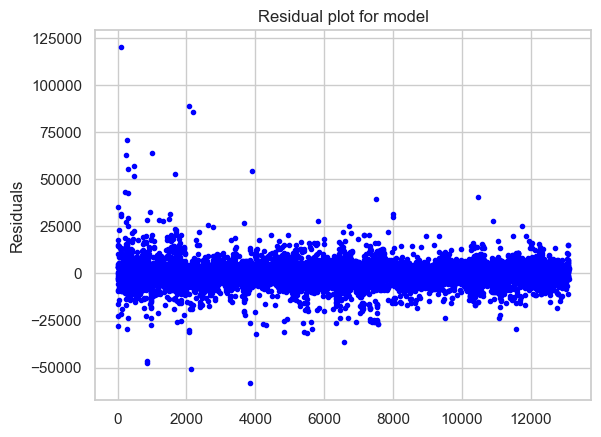

In [72]:
residual = y_test - y_pred_xgb
y_pred_xgb = pd.Series(y_pred_xgb)
y_pred_xgb.index = range(0,len(y_pred_xgb))
residual.index = range(0,len(residual))
a = pd.concat([residual,y_pred_xgb],axis=1,ignore_index=True)
resid_data = pd.DataFrame(a)
resid_data.columns = ['Residuals','Predicted']
plt.plot(resid_data['Residuals'], 'o', color='blue', markersize=3)
plt.title('Residual plot for model')
plt.ylabel('Residuals')
plt.show()

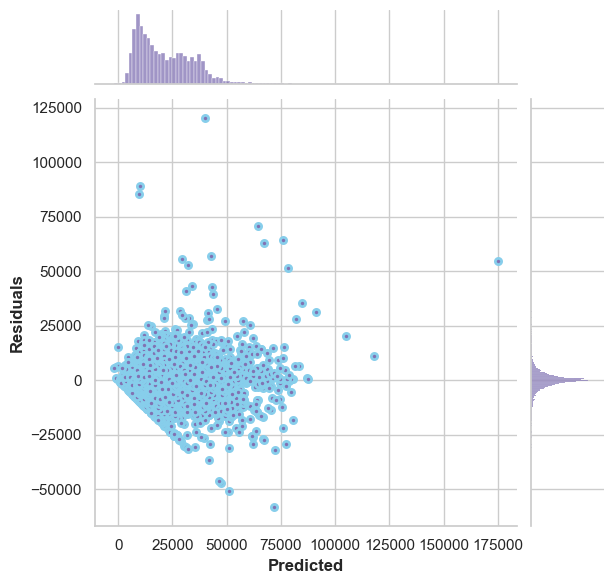

In [73]:
ax = sns.jointplot(x=resid_data['Predicted'], y=resid_data['Residuals'], kind='scatter', s=20, color='m', edgecolor="skyblue", linewidth=2)
ax.ax_joint.set_xlabel('Predicted', fontweight='bold')
ax.ax_joint.set_ylabel('Residuals', fontweight='bold')
plt.show()

This plot of residuals versus fits shows that the residual variance (vertical spread) increases as the fitted values (predicted values of sale price) increase. This violates the assumption of constant error variance.

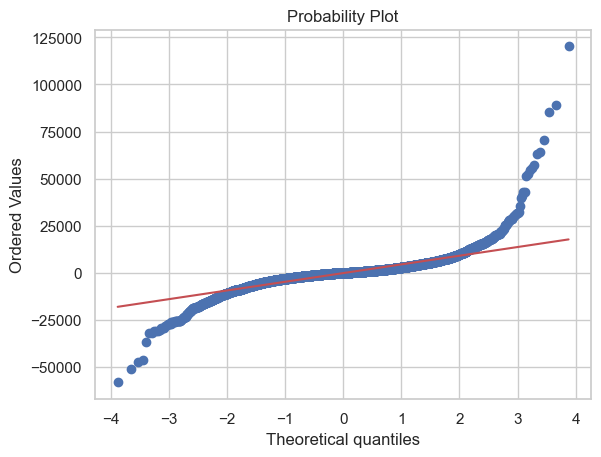

In [74]:
stats.probplot(resid_data['Residuals'], dist="norm", plot=pylab)
pylab.show()

The plot shows some deviation from the straight-line pattern indicating a distribution with heavier tails than a normal distribution.

#### Shapley values

In [76]:
xgb_hyp.fit(X_train_red, y_train);

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(xgb_hyp)
shap_values = explainer.shap_values(X_train_red)

# visualize the first prediction's explanation 
shap.initjs()

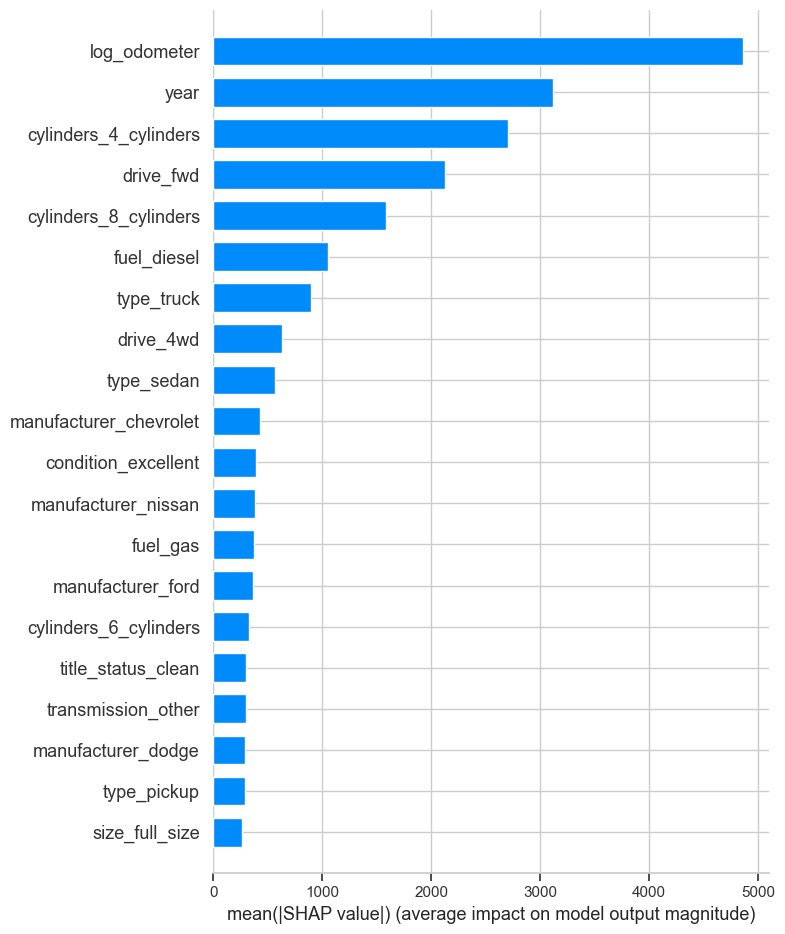

In [77]:
shap_values = shap.TreeExplainer(xgb_hyp).shap_values(X_train_red)
shap.summary_plot(shap_values, X_train_red, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


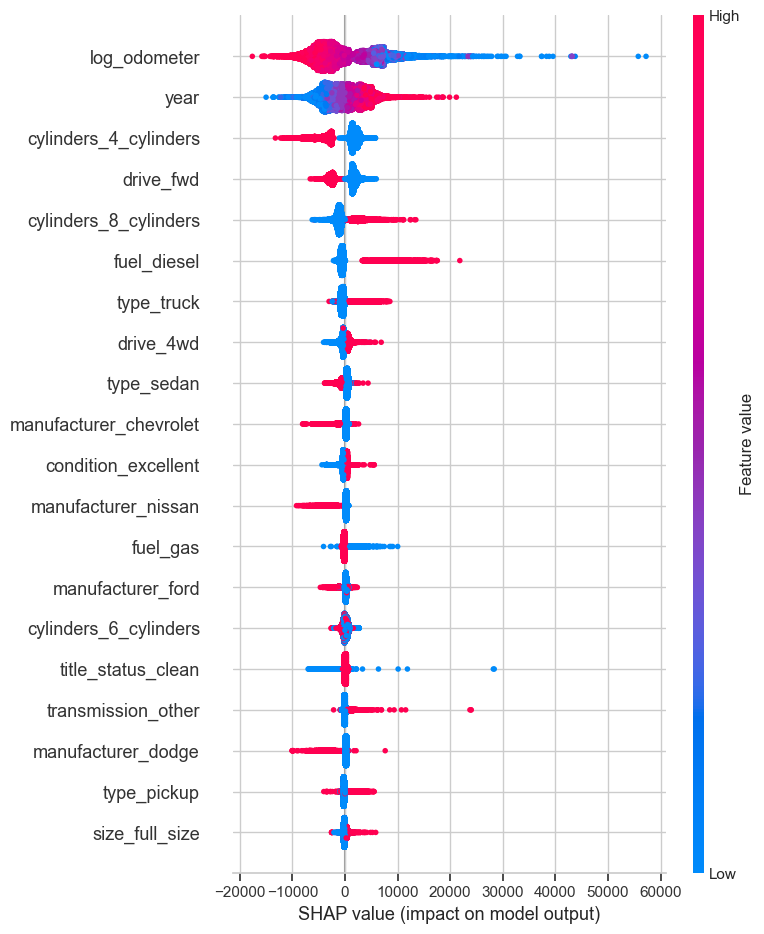

In [78]:
shap.summary_plot(shap_values, X_train_red)